Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# TensorFlow 1.15.2
# Also remember to use GPU in your colab notebook
%tensorflow_version 1.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1Y2gfhNgbGX7pA0FkA2vbOxdoSmNJVHIK'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1AGW9cRPwBmeJqOo3WXPPcNckrX4jMcIn'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1L-fnx31bK0nZAl9_DDfo7-25H7PYU0l8'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  13052
Number of dev sentences:  3263
Number of test sentences:  27625
Number of words in the training dataset:  13860
Number of words in the dev dataset:  6360
Number of words in the test dataset:  21696
Tags in the training dataset: ['B-treatment', 'I-problem', 'I-test', 'B-test', 'O', 'B-problem', 'I-treatment']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['B-treatment', 'I-problem', 'I-test', 'B-test', 'O', 'B-problem', 'I-treatment']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['B-treatment', 'I-problem', 'I-test', 'B-test', 'O', 'B-problem', 'I-treatment']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 10707,She,O
1,Sentence: 10707,had,O
2,Sentence: 10707,normal,O
3,Sentence: 10707,comprehension,O
4,Sentence: 10707,.,O
5,Sentence: 7349,Scott,O
6,Sentence: 7349,Robert,O
7,Sentence: 7349,NP,O
8,Sentence: 7349,80-AUM,O
9,Sentence: 7349,2017-06-29,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Last', 'O'),
 ('menstrual', 'O'),
 ('period', 'O'),
 ('2009-02-21', 'O'),
 ('.', 'O')]

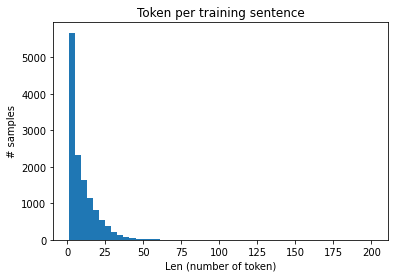

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

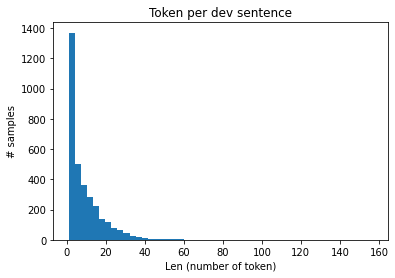

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

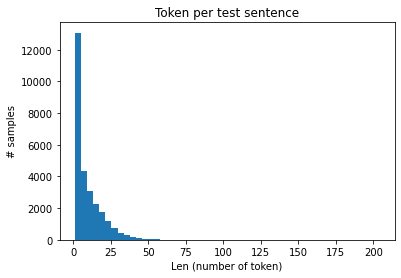

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'comprehension'
print(word2idx['comprehension'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-treatment'
print(tag2idx['B-treatment'])
# Tag of index 4
print(idx2tag[4])

6083
Insufficiency
0
O


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.75)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 13052
Points in y_train before removal: 13052
Points in X_train before removal: 3263
Points in y_train before removal: 3263


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[1263, 22630, 11319, 591, 20988, 19344, 18562, 10738, 17470, 21052, 14583, 417, 2952, 23277, 2952, 6308, 20077, 6418]
[4, 4, 4, 4, 4, 4, 4, 0, 6, 6, 4, 0, 4, 0, 4, 4, 0, 4]
[14712, 11319, 1821, 18562, 11306, 20728, 8343, 18860, 8884, 21065, 8270, 14446, 24430, 6418]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[5790, 22034, 11431]
[4, 4, 4]
6083
0
I-test
substance
28388
7


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 1.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.fillna(method="ffill")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 13.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 14.4 MB/s 
     |████████████████████████████████| 6.6 MB 70.9 MB/s 
     |████████████████████████████████| 596 kB 65.3 MB/s 
     |████████████████████████████████| 101 kB 12.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=bfcf1e4769c98008eeabe9068a36c007daadecb8ef1e1e561273c5a902f82e92
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[1263, 22630, 11319, 591, 20988, 19344, 18562, 10738, 17470, 21052, 14583, 417, 2952, 23277, 2952, 6308, 20077, 6418]
[4, 4, 4, 4, 4, 4, 4, 0, 6, 6, 4, 0, 4, 0, 4, 4, 0, 4]
[14712, 11319, 1821, 18562, 11306, 20728, 8343, 18860, 8884, 21065, 8270, 14446, 24430, 6418]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[5790, 22034, 11431]
[4, 4, 4]
6083
0
I-test
substance
28388
7


In [2]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [3]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [4]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

In [5]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 64:
    TRAIN_BATCH_SIZE = 64
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 64:
    VALID_BATCH_SIZE = 64
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [6]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [7]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [8]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [' '.join([idx2word[word] for word in sentence]) for sentence in augmented_X_train]
  X_dev_words = [' '.join([idx2word[word] for word in sentence]) for sentence in X_dev]
  X_test_words = [' '.join([idx2word[word] for word in sentence]) for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 3263
Points in y_train after augmentation: 3263
Device:  cuda


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8121955394744873
Training loss epoch: 0.38595226743057665
Training accuracy epoch: 0.88416686118892
Validating model...
Validation Loss: 0.20139690926846335
Validation Accuracy: 0.9374756847183318
Training epoch: 2
Training loss per 100 training steps: 0.4157322943210602
Training loss epoch: 0.10646739423128904
Training accuracy epoch: 0.9705785091814504
Validating model...
Validation Loss: 0.18166557776139064
Validation Accuracy: 0.9469878229069405
Training epoch: 3
Training loss per 100 training steps: 0.04620420187711716
Training loss epoch: 0.03870151737047469
Training accuracy epoch: 0.9895833333333334
Validating model...
Validation Loss: 0.19264568508986166
Validation Accuracy: 0.9491227046374106
Training epoch: 4
Training loss per 100 training steps: 0.07338850945234299
Training loss epoch: 0.029352440416593763
Training accuracy epoch: 0.9911151960784313
Validating model...
Validation Loss: 0.22555216243855802
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17814320472232928
Validation Accuracy: 0.9494719328703703
Validation duration: 2.1173792666666666 minutes
F1-score (test): 82.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.82      0.71      0.76      1170
        test       0.91      0.83      0.87      2464
   treatment       0.88      0.76      0.81      1244

   micro avg       0.88      0.78      0.83      4878
   macro avg       0.87      0.76      0.81      4878
weighted avg       0.88      0.78      0.83      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 3263
Points in y_train after augmentation: 3263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.67560613155365
Training loss epoch: 0.3279513233140403
Training accuracy epoch: 0.8976521164021164
Validating model...
Validation Loss: 0.19475221473212337
Validation Accuracy: 0.9381078820417055
Training epoch: 2
Training loss per 100 training steps: 0.13429096341133118
Training loss epoch: 0.08491675359397835
Training accuracy epoch: 0.9733358621226268
Validating model...
Validation Loss: 0.17192543392964438
Validation Accuracy: 0.9469780967942732
Training epoch: 3
Training loss per 100 training steps: 0.010308677330613136
Training loss epoch: 0.032454507352382526
Training accuracy epoch: 0.9905024509803921
Validating model...
Validation Loss: 0.20813373371264807
Validation Accuracy: 0.9515639589169002
Training epoch: 4
Training loss per 100 training steps: 0.002056346507743001
Training loss epoch: 0.01845804428426074
Training accuracy epoch: 0.9947916666666666
Validating model...
Validation Loss: 0.24633436106766263
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1708259963219192
Validation Accuracy: 0.9501909016485998
Validation duration: 2.1156567833333346 minutes
F1-score (test): 84.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.82      0.78      0.80      1170
        test       0.85      0.90      0.87      2464
   treatment       0.75      0.91      0.82      1244

   micro avg       0.81      0.87      0.84      4878
   macro avg       0.80      0.86      0.83      4878
weighted avg       0.81      0.87      0.84      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 3263
Points in y_train after augmentation: 3263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1077523231506348
Training loss epoch: 0.3619607162534022
Training accuracy epoch: 0.8869193510737629
Validating model...
Validation Loss: 0.18182689952207545
Validation Accuracy: 0.9445173902894491
Training epoch: 2
Training loss per 100 training steps: 0.11104957014322281
Training loss epoch: 0.10064911707213112
Training accuracy epoch: 0.968735410830999
Validating model...
Validation Loss: 0.15695556223976845
Validation Accuracy: 0.9503579209461562
Training epoch: 3
Training loss per 100 training steps: 0.06638306379318237
Training loss epoch: 0.04255894703023574
Training accuracy epoch: 0.9874387254901961
Validating model...
Validation Loss: 0.20166738773239593
Validation Accuracy: 0.9478972144413321
Training epoch: 4
Training loss per 100 training steps: 0.004141266457736492
Training loss epoch: 0.028998873573180067
Training accuracy epoch: 0.9920294506691565
Validating model...
Validation Loss: 0.2108351756709025
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15524257201684155
Validation Accuracy: 0.9519790608062331
Validation duration: 2.104054583333334 minutes
F1-score (test): 83.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.80      0.79      0.79      1170
        test       0.90      0.84      0.87      2464
   treatment       0.88      0.78      0.82      1244

   micro avg       0.87      0.81      0.84      4878
   macro avg       0.86      0.80      0.83      4878
weighted avg       0.87      0.81      0.84      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 3263
Points in y_train after augmentation: 3263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.088735580444336
Training loss epoch: 0.4048163875499192
Training accuracy epoch: 0.8758753501400559
Validating model...
Validation Loss: 0.22431787497857036
Validation Accuracy: 0.9172648225957049
Training epoch: 2
Training loss per 100 training steps: 0.13473959267139435
Training loss epoch: 0.1089470908228381
Training accuracy epoch: 0.9650589402427637
Validating model...
Validation Loss: 0.19207074778044925
Validation Accuracy: 0.9491227046374106
Training epoch: 3
Training loss per 100 training steps: 0.055978696793317795
Training loss epoch: 0.0343831546613764
Training accuracy epoch: 0.9920343137254902
Validating model...
Validation Loss: 0.17608648940336472
Validation Accuracy: 0.9527991752256458
Training epoch: 4
Training loss per 100 training steps: 0.0216017235070467
Training loss epoch: 0.019111331885534467
Training accuracy epoch: 0.9938676859632741
Validating model...
Validation Loss: 0.18617722682435722
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17168823565697056
Validation Accuracy: 0.9536428339543812
Validation duration: 2.1040622833333336 minutes
F1-score (test): 85.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.79      0.80      0.80      1170
        test       0.87      0.89      0.88      2464
   treatment       0.81      0.89      0.85      1244

   micro avg       0.84      0.87      0.85      4878
   macro avg       0.82      0.86      0.84      4878
weighted avg       0.84      0.87      0.85      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 3263
Points in y_train after augmentation: 3263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0628719329833984
Training loss epoch: 0.36396336175647437
Training accuracy epoch: 0.887848194833489
Validating model...
Validation Loss: 0.20553611715634665
Validation Accuracy: 0.9374805477746654
Training epoch: 2
Training loss per 100 training steps: 0.21102838218212128
Training loss epoch: 0.10334526060843001
Training accuracy epoch: 0.9693627450980392
Validating model...
Validation Loss: 0.1530635893417924
Validation Accuracy: 0.954642273576097
Training epoch: 3
Training loss per 100 training steps: 0.029793065041303635
Training loss epoch: 0.03589805547494953
Training accuracy epoch: 0.9904975879240584
Validating model...
Validation Loss: 0.19381417786958172
Validation Accuracy: 0.9497403127917833
Training epoch: 4
Training loss per 100 training steps: 0.00876393262296915
Training loss epoch: 0.023291531767623098
Training accuracy epoch: 0.9926373327108621
Validating model...
Validation Loss: 0.21587136384172767
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15530745481589325
Validation Accuracy: 0.9522119537601625
Validation duration: 2.1044399000000036 minutes
F1-score (test): 83.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.81      0.78      0.80      1170
        test       0.90      0.82      0.86      2464
   treatment       0.88      0.80      0.84      1244

   micro avg       0.87      0.81      0.84      4878
   macro avg       0.86      0.80      0.83      4878
weighted avg       0.87      0.81      0.84      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 3263
Points in y_train after augmentation: 3263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7360570430755615
Training loss epoch: 0.34396355493249847
Training accuracy epoch: 0.8939561935885465
Validating model...
Validation Loss: 0.1804579523410283
Validation Accuracy: 0.9436079987550576
Training epoch: 2
Training loss per 100 training steps: 0.06080160290002823
Training loss epoch: 0.09637572709470987
Training accuracy epoch: 0.9711912542794896
Validating model...
Validation Loss: 0.19030063124556168
Validation Accuracy: 0.9469829598506069
Training epoch: 3
Training loss per 100 training steps: 0.02486712671816349
Training loss epoch: 0.042745564735549336
Training accuracy epoch: 0.9877353719265484
Validating model...
Validation Loss: 0.19070034886838175
Validation Accuracy: 0.9436031356987239
Training epoch: 4
Training loss per 100 training steps: 0.04494018107652664
Training loss epoch: 0.018919720193462483
Training accuracy epoch: 0.9944804310613133
Validating model...
Validation Loss: 0.2768878080612779
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18306012863845186
Validation Accuracy: 0.9395775110094852
Validation duration: 2.1012938 minutes
F1-score (test): 80.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.67      0.81      0.74      1170
        test       0.87      0.85      0.86      2464
   treatment       0.94      0.65      0.77      1244

   micro avg       0.82      0.79      0.81      4878
   macro avg       0.83      0.77      0.79      4878
weighted avg       0.84      0.79      0.81      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 3263
Points in y_train after augmentation: 3263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0752978324890137
Training loss epoch: 0.35196515318809773
Training accuracy epoch: 0.8890834111422347
Validating model...
Validation Loss: 0.17466192911652959
Validation Accuracy: 0.9442158807967631
Training epoch: 2
Training loss per 100 training steps: 0.1312711387872696
Training loss epoch: 0.10392293348616245
Training accuracy epoch: 0.9669117647058824
Validating model...
Validation Loss: 0.16512817166307392
Validation Accuracy: 0.9506642934951759
Training epoch: 3
Training loss per 100 training steps: 0.050756923854351044
Training loss epoch: 0.028282287306900994
Training accuracy epoch: 0.9895784702769996
Validating model...
Validation Loss: 0.21026016797359084
Validation Accuracy: 0.9528040382819793
Training epoch: 4
Training loss per 100 training steps: 0.03280940651893616
Training loss epoch: 0.02847872187803481
Training accuracy epoch: 0.9917279411764706
Validating model...
Validation Loss: 0.20653901521719115
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16565820277146823
Validation Accuracy: 0.951513274898374
Validation duration: 2.115848033333335 minutes
F1-score (test): 83.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.88      0.70      0.78      1170
        test       0.87      0.86      0.86      2464
   treatment       0.91      0.75      0.82      1244

   micro avg       0.88      0.79      0.83      4878
   macro avg       0.89      0.77      0.82      4878
weighted avg       0.88      0.79      0.83      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 3263
Points in y_train after augmentation: 3263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.4443023204803467
Training loss epoch: 0.3763311825254384
Training accuracy epoch: 0.8832428804855276
Validating model...
Validation Loss: 0.20241331228730725
Validation Accuracy: 0.9356277233115468
Training epoch: 2
Training loss per 100 training steps: 0.05126745253801346
Training loss epoch: 0.0909991260508404
Training accuracy epoch: 0.9702769996887644
Validating model...
Validation Loss: 0.18992368358315206
Validation Accuracy: 0.9485196856520386
Training epoch: 3
Training loss per 100 training steps: 0.03757714480161667
Training loss epoch: 0.030958703865169312
Training accuracy epoch: 0.9911151960784313
Validating model...
Validation Loss: 0.22548942329982916
Validation Accuracy: 0.9469732337379395
Training epoch: 4
Training loss per 100 training steps: 0.004841451998800039
Training loss epoch: 0.027762800117260684
Training accuracy epoch: 0.9932598039215687
Validating model...
Validation Loss: 0.2187598518771576
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17522578106662776
Validation Accuracy: 0.9533058449074074
Validation duration: 2.1207239833333387 minutes
F1-score (test): 84.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.90      0.71      0.79      1170
        test       0.92      0.82      0.87      2464
   treatment       0.90      0.79      0.84      1244

   micro avg       0.91      0.79      0.84      4878
   macro avg       0.90      0.77      0.83      4878
weighted avg       0.91      0.79      0.84      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 3263
Points in y_train after augmentation: 3263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2027859687805176
Training loss epoch: 0.3955733005468752
Training accuracy epoch: 0.880787037037037
Validating model...
Validation Loss: 0.16927467476503522
Validation Accuracy: 0.946365351696234
Training epoch: 2
Training loss per 100 training steps: 0.05855630710721016
Training loss epoch: 0.11271767237899351
Training accuracy epoch: 0.9656814114534702
Validating model...
Validation Loss: 0.18899630627357492
Validation Accuracy: 0.9457574696545284
Training epoch: 3
Training loss per 100 training steps: 0.04312898963689804
Training loss epoch: 0.028256748332733325
Training accuracy epoch: 0.9935661764705882
Validating model...
Validation Loss: 0.2235806003651198
Validation Accuracy: 0.9454559601618425
Training epoch: 4
Training loss per 100 training steps: 0.0282583124935627
Training loss epoch: 0.02804361501087745
Training accuracy epoch: 0.9920343137254902
Validating model...
Validation Loss: 0.19321904669278392
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16651376247561225
Validation Accuracy: 0.9462167245370371
Validation duration: 2.117935366666673 minutes
F1-score (test): 82.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.79      0.72      0.75      1170
        test       0.84      0.88      0.86      2464
   treatment       0.80      0.87      0.83      1244

   micro avg       0.82      0.84      0.83      4878
   macro avg       0.81      0.82      0.81      4878
weighted avg       0.82      0.84      0.83      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 3263
Points in y_train after augmentation: 3263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9893877506256104
Training loss epoch: 0.3676764972361864
Training accuracy epoch: 0.8905958216619981
Validating model...
Validation Loss: 0.19054006989680083
Validation Accuracy: 0.9396348817304699
Training epoch: 2
Training loss per 100 training steps: 0.25510114431381226
Training loss epoch: 0.09855144489191327
Training accuracy epoch: 0.9696642545907251
Validating model...
Validation Loss: 0.15922214514484592
Validation Accuracy: 0.9518849206349206
Training epoch: 3
Training loss per 100 training steps: 0.07704484462738037
Training loss epoch: 0.028392203700016525
Training accuracy epoch: 0.9926470588235294
Validating model...
Validation Loss: 0.24378647560290262
Validation Accuracy: 0.9448188997821351
Training epoch: 4
Training loss per 100 training steps: 0.004530714359134436
Training loss epoch: 0.01819432557642679
Training accuracy epoch: 0.9935661764705882
Validating model...
Validation Loss: 0.23853296395984716
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15700631229534606
Validation Accuracy: 0.9536110758242999
Validation duration: 2.0913280833333223 minutes
F1-score (test): 84.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.81      0.78      0.80      1170
        test       0.87      0.89      0.88      2464
   treatment       0.91      0.77      0.83      1244

   micro avg       0.86      0.83      0.85      4878
   macro avg       0.86      0.81      0.83      4878
weighted avg       0.86      0.83      0.85      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 4079
Points in y_train after augmentation: 4079
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9963769912719727
Training loss epoch: 0.337996126152575
Training accuracy epoch: 0.8987491688829787
Validating model...
Validation Loss: 0.24969760423489645
Validation Accuracy: 0.9332010582010583
Training epoch: 2
Training loss per 100 training steps: 0.07333168387413025
Training loss epoch: 0.09447625077154953
Training accuracy epoch: 0.971923828125
Validating model...
Validation Loss: 0.1685006141516508
Validation Accuracy: 0.9546374105197635
Training epoch: 3
Training loss per 100 training steps: 0.017996374517679214
Training loss epoch: 0.039437513769371435
Training accuracy epoch: 0.98779296875
Validating model...
Validation Loss: 0.20911671743527346
Validation Accuracy: 0.9436079987550576
Training epoch: 4
Training loss per 100 training steps: 0.03915753215551376
Training loss epoch: 0.02551855489036825
Training accuracy epoch: 0.99169921875
Validating model...
Validation Loss: 0.20072895091017892
Validation Accuracy: 0.9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15455880196101066
Validation Accuracy: 0.9555844907407407
Validation duration: 2.1051872000000005 minutes
F1-score (test): 84.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.85      0.73      0.79      1170
        test       0.94      0.82      0.88      2464
   treatment       0.87      0.82      0.85      1244

   micro avg       0.90      0.80      0.85      4878
   macro avg       0.89      0.79      0.84      4878
weighted avg       0.90      0.80      0.85      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 4079
Points in y_train after augmentation: 4079
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.712664246559143
Training loss epoch: 0.31593351013725623
Training accuracy epoch: 0.9051851313164894
Validating model...
Validation Loss: 0.1811805335330028
Validation Accuracy: 0.9426937441643324
Training epoch: 2
Training loss per 100 training steps: 0.08492077887058258
Training loss epoch: 0.09021908670547418
Training accuracy epoch: 0.971435546875
Validating model...
Validation Loss: 0.17887428013936563
Validation Accuracy: 0.9506691565515094
Training epoch: 3
Training loss per 100 training steps: 0.046748142689466476
Training loss epoch: 0.04120109566792962
Training accuracy epoch: 0.9873046875
Validating model...
Validation Loss: 0.22324954862615057
Validation Accuracy: 0.9463750778089013
Training epoch: 4
Training loss per 100 training steps: 0.011586508713662624
Training loss epoch: 0.029883981163948192
Training accuracy epoch: 0.989990234375
Validating model...
Validation Loss: 0.23773356742572552
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16887001752426536
Validation Accuracy: 0.9518661430103884
Validation duration: 2.0868082499999976 minutes
F1-score (test): 83.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.83      0.76      0.79      1170
        test       0.87      0.88      0.87      2464
   treatment       0.84      0.76      0.80      1244

   micro avg       0.85      0.82      0.84      4878
   macro avg       0.85      0.80      0.82      4878
weighted avg       0.85      0.82      0.84      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 4079
Points in y_train after augmentation: 4079
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7550885677337646
Training loss epoch: 0.3420793729601428
Training accuracy epoch: 0.9002140126329787
Validating model...
Validation Loss: 0.18385128205751672
Validation Accuracy: 0.9448432150638033
Training epoch: 2
Training loss per 100 training steps: 0.04936181753873825
Training loss epoch: 0.09285530645865947
Training accuracy epoch: 0.9675085189494681
Validating model...
Validation Loss: 0.17371095764432468
Validation Accuracy: 0.9472893323996264
Training epoch: 3
Training loss per 100 training steps: 0.02129412814974785
Training loss epoch: 0.026683170483011054
Training accuracy epoch: 0.993408203125
Validating model...
Validation Loss: 0.20834928760122434
Validation Accuracy: 0.9451593137254902
Training epoch: 4
Training loss per 100 training steps: 0.028155790641903877
Training loss epoch: 0.011185382549228962
Training accuracy epoch: 0.997314453125
Validating model...
Validation Loss: 0.21227298883319484
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16252107213518616
Validation Accuracy: 0.9514409369354111
Validation duration: 2.08499439999999 minutes
F1-score (test): 83.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.87      0.69      0.77      1170
        test       0.90      0.85      0.87      2464
   treatment       0.78      0.88      0.83      1244

   micro avg       0.86      0.82      0.84      4878
   macro avg       0.85      0.81      0.82      4878
weighted avg       0.86      0.82      0.84      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 4079
Points in y_train after augmentation: 4079
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0375118255615234
Training loss epoch: 0.31924237369094044
Training accuracy epoch: 0.9012788813164894
Validating model...
Validation Loss: 0.1666394327493275
Validation Accuracy: 0.9451495876128229
Training epoch: 2
Training loss per 100 training steps: 0.07202969491481781
Training loss epoch: 0.09481349564885022
Training accuracy epoch: 0.9693058095079787
Validating model...
Validation Loss: 0.19095889093610002
Validation Accuracy: 0.9515882741985683
Training epoch: 3
Training loss per 100 training steps: 0.029903611168265343
Training loss epoch: 0.03501504371888586
Training accuracy epoch: 0.9891695063164894
Validating model...
Validation Loss: 0.22731808047084248
Validation Accuracy: 0.9485196856520386
Training epoch: 4
Training loss per 100 training steps: 0.008844957686960697
Training loss epoch: 0.024900343370973133
Training accuracy epoch: 0.992431640625
Validating model...
Validation Loss: 0.25395883237669137
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.163275154436835
Validation Accuracy: 0.9461399757226738
Validation duration: 2.086710349999991 minutes
F1-score (test): 82.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.66      0.83      0.74      1170
        test       0.86      0.89      0.88      2464
   treatment       0.86      0.80      0.83      1244

   micro avg       0.80      0.85      0.83      4878
   macro avg       0.79      0.84      0.81      4878
weighted avg       0.81      0.85      0.83      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 4079
Points in y_train after augmentation: 4079
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8510334491729736
Training loss epoch: 0.2972768399049528
Training accuracy epoch: 0.9047643783244681
Validating model...
Validation Loss: 0.1609103630716894
Validation Accuracy: 0.9491275676937441
Training epoch: 2
Training loss per 100 training steps: 0.07132332026958466
Training loss epoch: 0.09015068111330038
Training accuracy epoch: 0.9733003656914894
Validating model...
Validation Loss: 0.16622518645782097
Validation Accuracy: 0.9485148225957049
Training epoch: 3
Training loss per 100 training steps: 0.055439144372940063
Training loss epoch: 0.030585559068640578
Training accuracy epoch: 0.9912109375
Validating model...
Validation Loss: 0.24925370916139847
Validation Accuracy: 0.9408555088702147
Training epoch: 4
Training loss per 100 training steps: 0.02941995859146118
Training loss epoch: 0.018864656398363877
Training accuracy epoch: 0.9942964594414894
Validating model...
Validation Loss: 0.18890715830767638
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1618823738923917
Validation Accuracy: 0.947292972278681
Validation duration: 2.094579783333332 minutes
F1-score (test): 83.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.74      0.75      0.75      1170
        test       0.87      0.88      0.87      2464
   treatment       0.92      0.73      0.82      1244

   micro avg       0.85      0.81      0.83      4878
   macro avg       0.85      0.79      0.81      4878
weighted avg       0.85      0.81      0.83      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 4079
Points in y_train after augmentation: 4079
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0626978874206543
Training loss epoch: 0.34571230300934985
Training accuracy epoch: 0.8961519281914894
Validating model...
Validation Loss: 0.17329504472367904
Validation Accuracy: 0.9454462340491753
Training epoch: 2
Training loss per 100 training steps: 0.04876399040222168
Training loss epoch: 0.07824823414557613
Training accuracy epoch: 0.9747652094414894
Validating model...
Validation Loss: 0.26820136332774863
Validation Accuracy: 0.9356374494242141
Training epoch: 3
Training loss per 100 training steps: 0.06690099090337753
Training loss epoch: 0.037434219928400125
Training accuracy epoch: 0.988525390625
Validating model...
Validation Loss: 0.19663676854643022
Validation Accuracy: 0.9497403127917833
Training epoch: 4
Training loss per 100 training steps: 0.006463575176894665
Training loss epoch: 0.022197283466084627
Training accuracy epoch: 0.991943359375
Validating model...
Validation Loss: 0.26514751997356323
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16355020513206167
Validation Accuracy: 0.9471888761856369
Validation duration: 2.089780033333333 minutes
F1-score (test): 82.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.83      0.65      0.73      1170
        test       0.89      0.85      0.87      2464
   treatment       0.82      0.83      0.83      1244

   micro avg       0.86      0.80      0.83      4878
   macro avg       0.85      0.78      0.81      4878
weighted avg       0.86      0.80      0.82      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 4079
Points in y_train after augmentation: 4079
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.742414951324463
Training loss epoch: 0.3251174187171273
Training accuracy epoch: 0.8972635472074468
Validating model...
Validation Loss: 0.1746954844132358
Validation Accuracy: 0.9494290771864301
Training epoch: 2
Training loss per 100 training steps: 0.06162508577108383
Training loss epoch: 0.0808486715395702
Training accuracy epoch: 0.9757417719414894
Validating model...
Validation Loss: 0.183625587645699
Validation Accuracy: 0.946063842203548
Training epoch: 3
Training loss per 100 training steps: 0.020492324605584145
Training loss epoch: 0.027122890067403205
Training accuracy epoch: 0.9918550531914894
Validating model...
Validation Loss: 0.2194144804688061
Validation Accuracy: 0.9442353330220976
Training epoch: 4
Training loss per 100 training steps: 0.03263334929943085
Training loss epoch: 0.02370715472352458
Training accuracy epoch: 0.9930757563164894
Validating model...
Validation Loss: 0.19697702091698552
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17344207440813383
Validation Accuracy: 0.9487079734078591
Validation duration: 2.0878923999999945 minutes
F1-score (test): 82.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.88      0.64      0.74      1170
        test       0.84      0.87      0.86      2464
   treatment       0.88      0.78      0.83      1244

   micro avg       0.86      0.79      0.82      4878
   macro avg       0.87      0.76      0.81      4878
weighted avg       0.86      0.79      0.82      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 4079
Points in y_train after augmentation: 4079
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9634404182434082
Training loss epoch: 0.3150142166996375
Training accuracy epoch: 0.9011022689494681
Validating model...
Validation Loss: 0.17100154542747667
Validation Accuracy: 0.9500466853408029
Training epoch: 2
Training loss per 100 training steps: 0.04829353839159012
Training loss epoch: 0.08649306406732649
Training accuracy epoch: 0.9731237533244681
Validating model...
Validation Loss: 0.18886179849505424
Validation Accuracy: 0.9463556255835668
Training epoch: 3
Training loss per 100 training steps: 0.03062368743121624
Training loss epoch: 0.03812985060721985
Training accuracy epoch: 0.988037109375
Validating model...
Validation Loss: 0.18954901506795602
Validation Accuracy: 0.9500515483971367
Training epoch: 4
Training loss per 100 training steps: 0.00483097555115819
Training loss epoch: 0.019619241284090094
Training accuracy epoch: 0.994384765625
Validating model...
Validation Loss: 0.19603856247575843
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1631402242023291
Validation Accuracy: 0.9508939913617886
Validation duration: 2.085318750000018 minutes
F1-score (test): 83.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.79      0.75      0.77      1170
        test       0.91      0.82      0.86      2464
   treatment       0.92      0.80      0.85      1244

   micro avg       0.88      0.80      0.84      4878
   macro avg       0.87      0.79      0.83      4878
weighted avg       0.88      0.80      0.84      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 4079
Points in y_train after augmentation: 4079
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1992111206054688
Training loss epoch: 0.34249807335436344
Training accuracy epoch: 0.8953987283909575
Validating model...
Validation Loss: 0.18178445845842361
Validation Accuracy: 0.9420761360099595
Training epoch: 2
Training loss per 100 training steps: 0.19230744242668152
Training loss epoch: 0.08559816182241775
Training accuracy epoch: 0.9747652094414894
Validating model...
Validation Loss: 0.18907147949086686
Validation Accuracy: 0.9475908418923125
Training epoch: 3
Training loss per 100 training steps: 0.03992621973156929
Training loss epoch: 0.03532877064571949
Training accuracy epoch: 0.987548828125
Validating model...
Validation Loss: 0.18714335315185143
Validation Accuracy: 0.9561789993775288
Training epoch: 4
Training loss per 100 training steps: 0.006264540832489729
Training loss epoch: 0.01397517508121382
Training accuracy epoch: 0.99560546875
Validating model...
Validation Loss: 0.21367606095166183
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1755957854092466
Validation Accuracy: 0.9456697789634146
Validation duration: 2.0786822499999897 minutes
F1-score (test): 81.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.67      0.75      1170
        test       0.81      0.90      0.85      2464
   treatment       0.94      0.68      0.79      1244

   micro avg       0.85      0.79      0.82      4878
   macro avg       0.87      0.75      0.80      4878
weighted avg       0.86      0.79      0.81      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 4079
Points in y_train after augmentation: 4079
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.019015312194824
Training loss epoch: 0.3240419411449693
Training accuracy epoch: 0.9007022938829787
Validating model...
Validation Loss: 0.17109709948885674
Validation Accuracy: 0.9448334889511361
Training epoch: 2
Training loss per 100 training steps: 0.07637207210063934
Training loss epoch: 0.08484131097793579
Training accuracy epoch: 0.9737003407579787
Validating model...
Validation Loss: 0.18353967145815783
Validation Accuracy: 0.9494290771864301
Training epoch: 3
Training loss per 100 training steps: 0.012268909253180027
Training loss epoch: 0.033391452012438094
Training accuracy epoch: 0.9892578125
Validating model...
Validation Loss: 0.19150752939429938
Validation Accuracy: 0.9518946467475878
Training epoch: 4
Training loss per 100 training steps: 0.011721763759851456
Training loss epoch: 0.0169558369598235
Training accuracy epoch: 0.99609375
Validating model...
Validation Loss: 0.23036591787183403
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16270876923765712
Validation Accuracy: 0.9491058322041553
Validation duration: 2.074290950000007 minutes
F1-score (test): 83.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.85      0.67      0.75      1170
        test       0.82      0.91      0.86      2464
   treatment       0.83      0.87      0.85      1244

   micro avg       0.83      0.84      0.84      4878
   macro avg       0.84      0.82      0.82      4878
weighted avg       0.83      0.84      0.83      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 4895
Points in y_train after augmentation: 4895
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6848326921463013
Training loss epoch: 0.3205245113992072
Training accuracy epoch: 0.9035858294930876
Validating model...
Validation Loss: 0.19747715545635597
Validation Accuracy: 0.9393139200124494
Training epoch: 2
Training loss per 100 training steps: 0.14392220973968506
Training loss epoch: 0.08804440736625489
Training accuracy epoch: 0.9703341013824885
Validating model...
Validation Loss: 0.17339028096666523
Validation Accuracy: 0.9482035869903517
Training epoch: 3
Training loss per 100 training steps: 0.015135081484913826
Training loss epoch: 0.03652505646157381
Training accuracy epoch: 0.9886363636363636
Validating model...
Validation Loss: 0.18494157602681832
Validation Accuracy: 0.9521621148459383
Training epoch: 4
Training loss per 100 training steps: 0.003969241864979267
Training loss epoch: 0.012268516443693986
Training accuracy epoch: 0.9965503246753247
Validating model...
Validation Loss: 0.20120710134962758
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17239587834316167
Validation Accuracy: 0.9534214092140921
Validation duration: 2.077615433333358 minutes
F1-score (test): 84.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.83      0.77      0.80      1170
        test       0.88      0.88      0.88      2464
   treatment       0.75      0.89      0.81      1244

   micro avg       0.83      0.85      0.84      4878
   macro avg       0.82      0.84      0.83      4878
weighted avg       0.83      0.85      0.84      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 4895
Points in y_train after augmentation: 4895
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1935617923736572
Training loss epoch: 0.32094226056685693
Training accuracy epoch: 0.8999332320904901
Validating model...
Validation Loss: 0.15561274877365897
Validation Accuracy: 0.9512673124805477
Training epoch: 2
Training loss per 100 training steps: 0.13076049089431763
Training loss epoch: 0.07569653469488605
Training accuracy epoch: 0.9784902597402597
Validating model...
Validation Loss: 0.17924291187641667
Validation Accuracy: 0.942698607220666
Training epoch: 3
Training loss per 100 training steps: 0.02164134755730629
Training loss epoch: 0.03754777467035531
Training accuracy epoch: 0.9898538961038961
Validating model...
Validation Loss: 0.16353262472422977
Validation Accuracy: 0.9589412153750388
Training epoch: 4
Training loss per 100 training steps: 0.0033582088071852922
Training loss epoch: 0.017422681240449576
Training accuracy epoch: 0.9945211038961039
Validating model...
Validation Loss: 0.18506200636243997
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1630779120777906
Validation Accuracy: 0.9479687147131889
Validation duration: 2.092540500000026 minutes
F1-score (test): 82.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.83      0.71      0.76      1170
        test       0.82      0.89      0.85      2464
   treatment       0.89      0.75      0.82      1244

   micro avg       0.84      0.81      0.82      4878
   macro avg       0.85      0.79      0.81      4878
weighted avg       0.84      0.81      0.82      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 4895
Points in y_train after augmentation: 4895
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.795810341835022
Training loss epoch: 0.27848128451929466
Training accuracy epoch: 0.9143668831168831
Validating model...
Validation Loss: 0.21561401395821103
Validation Accuracy: 0.9347134687208216
Training epoch: 2
Training loss per 100 training steps: 0.10811305046081543
Training loss epoch: 0.08332634917399906
Training accuracy epoch: 0.9738099602010892
Validating model...
Validation Loss: 0.15147246672388384
Validation Accuracy: 0.9586299797696857
Training epoch: 3
Training loss per 100 training steps: 0.01756978966295719
Training loss epoch: 0.030428335888541075
Training accuracy epoch: 0.9910714285714286
Validating model...
Validation Loss: 0.24689857175975455
Validation Accuracy: 0.9491178415810768
Training epoch: 4
Training loss per 100 training steps: 0.00333954393863678
Training loss epoch: 0.023553754925703656
Training accuracy epoch: 0.9922758692919983
Validating model...
Validation Loss: 0.2539876735239637
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15727105708059821
Validation Accuracy: 0.9557406348803071
Validation duration: 2.0829144333333414 minutes
F1-score (test): 85.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.81      0.78      0.79      1170
        test       0.85      0.91      0.88      2464
   treatment       0.92      0.80      0.86      1244

   micro avg       0.86      0.85      0.85      4878
   macro avg       0.86      0.83      0.84      4878
weighted avg       0.86      0.85      0.85      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 4895
Points in y_train after augmentation: 4895
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2410576343536377
Training loss epoch: 0.31055343189796847
Training accuracy epoch: 0.9074544407205698
Validating model...
Validation Loss: 0.17626265984247713
Validation Accuracy: 0.9408409197012139
Training epoch: 2
Training loss per 100 training steps: 0.10273220390081406
Training loss epoch: 0.09153787940498684
Training accuracy epoch: 0.9709559593632174
Validating model...
Validation Loss: 0.18077983838670394
Validation Accuracy: 0.9546471366324307
Training epoch: 3
Training loss per 100 training steps: 0.022435173392295837
Training loss epoch: 0.03985968122996583
Training accuracy epoch: 0.987012987012987
Validating model...
Validation Loss: 0.196060324489486
Validation Accuracy: 0.9543456271397447
Training epoch: 4
Training loss per 100 training steps: 0.021705888211727142
Training loss epoch: 0.014722140656342706
Training accuracy epoch: 0.9957386363636364
Validating model...
Validation Loss: 0.2562372518860845
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17806445188492676
Validation Accuracy: 0.9439539577687444
Validation duration: 2.09351148333332 minutes
F1-score (test): 80.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.68      0.80      0.73      1170
        test       0.90      0.81      0.85      2464
   treatment       0.85      0.77      0.81      1244

   micro avg       0.82      0.79      0.81      4878
   macro avg       0.81      0.79      0.80      4878
weighted avg       0.83      0.79      0.81      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 4895
Points in y_train after augmentation: 4895
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9436596632003784
Training loss epoch: 0.3067532285273849
Training accuracy epoch: 0.9058310640971932
Validating model...
Validation Loss: 0.17846519302795916
Validation Accuracy: 0.9448480781201368
Training epoch: 2
Training loss per 100 training steps: 0.10766353458166122
Training loss epoch: 0.08466239475536269
Training accuracy epoch: 0.9746347402597403
Validating model...
Validation Loss: 0.18077248044531136
Validation Accuracy: 0.9445173902894491
Training epoch: 3
Training loss per 100 training steps: 0.011977022513747215
Training loss epoch: 0.030043326916971376
Training accuracy epoch: 0.9910583368244659
Validating model...
Validation Loss: 0.21165706315899596
Validation Accuracy: 0.9500515483971367
Training epoch: 4
Training loss per 100 training steps: 0.00448966771364212
Training loss epoch: 0.013613729936512211
Training accuracy epoch: 0.9965372329283619
Validating model...
Validation Loss: 0.2104574102524887
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1716616810773741
Validation Accuracy: 0.9440986336946703
Validation duration: 2.0892019666666783 minutes
F1-score (test): 81.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.74      0.74      0.74      1170
        test       0.94      0.75      0.83      2464
   treatment       0.89      0.80      0.84      1244

   micro avg       0.87      0.76      0.81      4878
   macro avg       0.86      0.76      0.81      4878
weighted avg       0.88      0.76      0.81      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 4895
Points in y_train after augmentation: 4895
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8376057147979736
Training loss epoch: 0.32796536415041266
Training accuracy epoch: 0.901543516966904
Validating model...
Validation Loss: 0.1814531889908454
Validation Accuracy: 0.9448383520074696
Training epoch: 2
Training loss per 100 training steps: 0.07756383717060089
Training loss epoch: 0.08373667471497864
Training accuracy epoch: 0.9762581168831169
Validating model...
Validation Loss: 0.17641713280303806
Validation Accuracy: 0.9506691565515094
Training epoch: 3
Training loss per 100 training steps: 0.022479834035038948
Training loss epoch: 0.03216086539693854
Training accuracy epoch: 0.9908554147465438
Validating model...
Validation Loss: 0.19347764741556317
Validation Accuracy: 0.9512770385932151
Training epoch: 4
Training loss per 100 training steps: 0.006283269263803959
Training loss epoch: 0.019642619083502462
Training accuracy epoch: 0.9951298701298701
Validating model...
Validation Loss: 0.216710585196886
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17493816062967568
Validation Accuracy: 0.9520875677506775
Validation duration: 2.086970799999987 minutes
F1-score (test): 83.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.79      0.75      0.77      1170
        test       0.92      0.81      0.86      2464
   treatment       0.85      0.85      0.85      1244

   micro avg       0.87      0.81      0.84      4878
   macro avg       0.85      0.80      0.83      4878
weighted avg       0.87      0.81      0.84      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 4895
Points in y_train after augmentation: 4895
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.053332567214966
Training loss epoch: 0.3091500817568271
Training accuracy epoch: 0.9005419983242564
Validating model...
Validation Loss: 0.179833415457431
Validation Accuracy: 0.9405442732648615
Training epoch: 2
Training loss per 100 training steps: 0.12221742421388626
Training loss epoch: 0.08176279539702
Training accuracy epoch: 0.9746085567658148
Validating model...
Validation Loss: 0.1931839298602997
Validation Accuracy: 0.949443666355431
Training epoch: 3
Training loss per 100 training steps: 0.07346047461032867
Training loss epoch: 0.030535089006260424
Training accuracy epoch: 0.9908685064935064
Validating model...
Validation Loss: 0.23180923501358314
Validation Accuracy: 0.9463702147525677
Training epoch: 4
Training loss per 100 training steps: 0.004766950849443674
Training loss epoch: 0.015692018085104932
Training accuracy epoch: 0.9951298701298701
Validating model...
Validation Loss: 0.2333028012448374
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17196879738131193
Validation Accuracy: 0.9440465856481481
Validation duration: 2.0922762500000016 minutes
F1-score (test): 80.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.92      0.60      0.73      1170
        test       0.94      0.78      0.85      2464
   treatment       0.92      0.69      0.79      1244

   micro avg       0.93      0.72      0.81      4878
   macro avg       0.93      0.69      0.79      4878
weighted avg       0.93      0.72      0.81      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 4895
Points in y_train after augmentation: 4895
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6365785598754883
Training loss epoch: 0.29069011774543047
Training accuracy epoch: 0.9155451403435275
Validating model...
Validation Loss: 0.16346606042455225
Validation Accuracy: 0.9494290771864301
Training epoch: 2
Training loss per 100 training steps: 0.02795899659395218
Training loss epoch: 0.07583542073193889
Training accuracy epoch: 0.9778814935064936
Validating model...
Validation Loss: 0.1845942112964158
Validation Accuracy: 0.953411920323685
Training epoch: 3
Training loss per 100 training steps: 0.006206195335835218
Training loss epoch: 0.02797963125207885
Training accuracy epoch: 0.9931006493506493
Validating model...
Validation Loss: 0.24698654065986037
Validation Accuracy: 0.9506545673825085
Training epoch: 4
Training loss per 100 training steps: 0.001890182844363153
Training loss epoch: 0.020198187349339973
Training accuracy epoch: 0.9951298701298701
Validating model...
Validation Loss: 0.22499873678145163
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15982088570362302
Validation Accuracy: 0.9517461678523035
Validation duration: 2.0856840333333215 minutes
F1-score (test): 84.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.81      0.74      0.77      1170
        test       0.86      0.87      0.87      2464
   treatment       0.88      0.82      0.85      1244

   micro avg       0.86      0.83      0.84      4878
   macro avg       0.85      0.81      0.83      4878
weighted avg       0.86      0.83      0.84      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 4895
Points in y_train after augmentation: 4895
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8951534032821655
Training loss epoch: 0.29965963253340167
Training accuracy epoch: 0.9038018433179723
Validating model...
Validation Loss: 0.19710004497684686
Validation Accuracy: 0.939017273576097
Training epoch: 2
Training loss per 100 training steps: 0.13766326010227203
Training loss epoch: 0.08671964777560977
Training accuracy epoch: 0.9744056346878928
Validating model...
Validation Loss: 0.16231993129294292
Validation Accuracy: 0.9506740196078431
Training epoch: 3
Training loss per 100 training steps: 0.0909411609172821
Training loss epoch: 0.03666134148098335
Training accuracy epoch: 0.9888392857142857
Validating model...
Validation Loss: 0.205060834010296
Validation Accuracy: 0.9488309212573918
Training epoch: 4
Training loss per 100 training steps: 0.03933986648917198
Training loss epoch: 0.01616062784708081
Training accuracy epoch: 0.9955357142857143
Validating model...
Validation Loss: 0.2385360617555824
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15597758690516153
Validation Accuracy: 0.9534099410004516
Validation duration: 2.0889900833333135 minutes
F1-score (test): 84.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.76      0.80      0.78      1170
        test       0.87      0.89      0.88      2464
   treatment       0.80      0.89      0.84      1244

   micro avg       0.83      0.87      0.85      4878
   macro avg       0.81      0.86      0.83      4878
weighted avg       0.83      0.87      0.85      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 4895
Points in y_train after augmentation: 4895
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1456472873687744
Training loss epoch: 0.3152760798232509
Training accuracy epoch: 0.8991346355257646
Validating model...
Validation Loss: 0.19275327614855534
Validation Accuracy: 0.9402427637721754
Training epoch: 2
Training loss per 100 training steps: 0.029432181268930435
Training loss epoch: 0.08184741982924086
Training accuracy epoch: 0.9760551948051948
Validating model...
Validation Loss: 0.17749805879943512
Validation Accuracy: 0.9469829598506069
Training epoch: 3
Training loss per 100 training steps: 0.02601129747927189
Training loss epoch: 0.03133015104194547
Training accuracy epoch: 0.9902466485127775
Validating model...
Validation Loss: 0.2555099946684113
Validation Accuracy: 0.9365614301276066
Training epoch: 4
Training loss per 100 training steps: 0.0709100216627121
Training loss epoch: 0.028377402578359592
Training accuracy epoch: 0.9912743506493507
Validating model...
Validation Loss: 0.24619933429594135
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17858609861556302
Validation Accuracy: 0.9501026846205962
Validation duration: 2.087488850000015 minutes
F1-score (test): 83.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.70      0.84      0.76      1170
        test       0.86      0.89      0.87      2464
   treatment       0.91      0.76      0.83      1244

   micro avg       0.83      0.84      0.83      4878
   macro avg       0.82      0.83      0.82      4878
weighted avg       0.83      0.84      0.84      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 5711
Points in y_train after augmentation: 5711
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.912013292312622
Training loss epoch: 0.2903237822569079
Training accuracy epoch: 0.9088541666666666
Validating model...
Validation Loss: 0.16649011621142135
Validation Accuracy: 0.951880057578587
Training epoch: 2
Training loss per 100 training steps: 0.04966965690255165
Training loss epoch: 0.07733534197323025
Training accuracy epoch: 0.9763888888888889
Validating model...
Validation Loss: 0.16162227941494361
Validation Accuracy: 0.9552501556178027
Training epoch: 3
Training loss per 100 training steps: 0.016654832288622856
Training loss epoch: 0.025649356049123325
Training accuracy epoch: 0.9927083333333333
Validating model...
Validation Loss: 0.20672144729406663
Validation Accuracy: 0.9534167833800186
Training epoch: 4
Training loss per 100 training steps: 0.0013891091803088784
Training loss epoch: 0.010388159862486646
Training accuracy epoch: 0.9975694444444444
Validating model...
Validation Loss: 0.2401465024689541
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15438795262835575
Validation Accuracy: 0.9554309931120144
Validation duration: 2.094923866666674 minutes
F1-score (test): 84.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.88      0.70      0.78      1170
        test       0.90      0.87      0.88      2464
   treatment       0.83      0.85      0.84      1244

   micro avg       0.88      0.82      0.85      4878
   macro avg       0.87      0.81      0.83      4878
weighted avg       0.88      0.82      0.85      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 5711
Points in y_train after augmentation: 5711
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.953425407409668
Training loss epoch: 0.281855392207702
Training accuracy epoch: 0.9092013888888889
Validating model...
Validation Loss: 0.1760465019181663
Validation Accuracy: 0.9488211951447245
Training epoch: 2
Training loss per 100 training steps: 0.11455395072698593
Training loss epoch: 0.06447951143814458
Training accuracy epoch: 0.9805555555555555
Validating model...
Validation Loss: 0.17946610121312095
Validation Accuracy: 0.9506545673825085
Training epoch: 3
Training loss per 100 training steps: 0.040849123150110245
Training loss epoch: 0.022165710734488028
Training accuracy epoch: 0.9928819444444444
Validating model...
Validation Loss: 0.22873468865074364
Validation Accuracy: 0.9475908418923125
Training epoch: 4
Training loss per 100 training steps: 0.04686755686998367
Training loss epoch: 0.01783373377564001
Training accuracy epoch: 0.9953125
Validating model...
Validation Loss: 0.23080473527421846
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16775138307949183
Validation Accuracy: 0.9478355070009032
Validation duration: 2.0927228666666755 minutes
F1-score (test): 83.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.77      0.77      1170
        test       0.86      0.88      0.87      2464
   treatment       0.79      0.85      0.82      1244

   micro avg       0.82      0.84      0.83      4878
   macro avg       0.81      0.83      0.82      4878
weighted avg       0.82      0.84      0.83      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 5711
Points in y_train after augmentation: 5711
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9768650531768799
Training loss epoch: 0.2702905234363344
Training accuracy epoch: 0.9151041666666667
Validating model...
Validation Loss: 0.1788733512455342
Validation Accuracy: 0.9485148225957049
Training epoch: 2
Training loss per 100 training steps: 0.13249479234218597
Training loss epoch: 0.06515618114111324
Training accuracy epoch: 0.9805555555555555
Validating model...
Validation Loss: 0.1881386004114414
Validation Accuracy: 0.9488017429193899
Training epoch: 3
Training loss per 100 training steps: 0.04944086819887161
Training loss epoch: 0.032529366687069544
Training accuracy epoch: 0.9902777777777778
Validating model...
Validation Loss: 0.19938358005282342
Validation Accuracy: 0.9537037037037036
Training epoch: 4
Training loss per 100 training steps: 0.008571302518248558
Training loss epoch: 0.016450314523212405
Training accuracy epoch: 0.9953125
Validating model...
Validation Loss: 0.203862519898251
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16874081914149294
Validation Accuracy: 0.9468386545844625
Validation duration: 2.0851255666666475 minutes
F1-score (test): 82.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.76      0.76      1170
        test       0.90      0.83      0.86      2464
   treatment       0.87      0.75      0.81      1244

   micro avg       0.86      0.79      0.83      4878
   macro avg       0.85      0.78      0.81      4878
weighted avg       0.86      0.79      0.83      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 5711
Points in y_train after augmentation: 5711
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8611783981323242
Training loss epoch: 0.277917099578513
Training accuracy epoch: 0.9147569444444444
Validating model...
Validation Loss: 0.18238412490224137
Validation Accuracy: 0.9380932928727046
Training epoch: 2
Training loss per 100 training steps: 0.11812011897563934
Training loss epoch: 0.07411582584803303
Training accuracy epoch: 0.9784722222222222
Validating model...
Validation Loss: 0.16148216785023026
Validation Accuracy: 0.9524830765639589
Training epoch: 3
Training loss per 100 training steps: 0.026589136570692062
Training loss epoch: 0.03775531358551234
Training accuracy epoch: 0.9876736111111111
Validating model...
Validation Loss: 0.1922334241772107
Validation Accuracy: 0.9521912931839401
Training epoch: 4
Training loss per 100 training steps: 0.0031684364657849073
Training loss epoch: 0.01828504203650583
Training accuracy epoch: 0.9946180555555556
Validating model...
Validation Loss: 0.26835096621310667
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16495372649256346
Validation Accuracy: 0.9501909016485998
Validation duration: 2.1062843333333756 minutes
F1-score (test): 83.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.74      0.79      0.77      1170
        test       0.87      0.86      0.87      2464
   treatment       0.89      0.83      0.86      1244

   micro avg       0.84      0.84      0.84      4878
   macro avg       0.83      0.83      0.83      4878
weighted avg       0.84      0.84      0.84      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 5711
Points in y_train after augmentation: 5711
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.866272211074829
Training loss epoch: 0.2903735477063391
Training accuracy epoch: 0.9093287037037038
Validating model...
Validation Loss: 0.17120283067810768
Validation Accuracy: 0.9503384687208216
Training epoch: 2
Training loss per 100 training steps: 0.027483731508255005
Training loss epoch: 0.07362791823430194
Training accuracy epoch: 0.9754745370370371
Validating model...
Validation Loss: 0.18289364604096786
Validation Accuracy: 0.9509658029878617
Training epoch: 3
Training loss per 100 training steps: 0.026918625459074974
Training loss epoch: 0.03580573164314652
Training accuracy epoch: 0.9907986111111111
Validating model...
Validation Loss: 0.21971150568923822
Validation Accuracy: 0.9500418222844693
Training epoch: 4
Training loss per 100 training steps: 0.008780027739703655
Training loss epoch: 0.017083763379034483
Training accuracy epoch: 0.9942708333333333
Validating model...
Validation Loss: 0.20672398506134165
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15765057446831768
Validation Accuracy: 0.9495919080284553
Validation duration: 2.085932383333299 minutes
F1-score (test): 83.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.75      0.77      0.76      1170
        test       0.90      0.85      0.87      2464
   treatment       0.84      0.84      0.84      1244

   micro avg       0.85      0.83      0.84      4878
   macro avg       0.83      0.82      0.82      4878
weighted avg       0.85      0.83      0.84      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 5711
Points in y_train after augmentation: 5711
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0494613647460938
Training loss epoch: 0.2963511004216141
Training accuracy epoch: 0.9137152777777777
Validating model...
Validation Loss: 0.21414820849895477
Validation Accuracy: 0.9384093915343915
Training epoch: 2
Training loss per 100 training steps: 0.08706468343734741
Training loss epoch: 0.07016200407718619
Training accuracy epoch: 0.9800347222222222
Validating model...
Validation Loss: 0.19178264891253968
Validation Accuracy: 0.9509803921568627
Training epoch: 3
Training loss per 100 training steps: 0.014887358993291855
Training loss epoch: 0.024567254796986366
Training accuracy epoch: 0.99375
Validating model...
Validation Loss: 0.21311403728802414
Validation Accuracy: 0.9555565281668222
Training epoch: 4
Training loss per 100 training steps: 0.0018720829393714666
Training loss epoch: 0.013077342783799396
Training accuracy epoch: 0.9953125
Validating model...
Validation Loss: 0.2478264379223772
Validation Accuracy: 0.949

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18949705961751062
Validation Accuracy: 0.95141623616757
Validation duration: 2.0870947666666324 minutes
F1-score (test): 83.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.85      0.67      0.75      1170
        test       0.87      0.88      0.87      2464
   treatment       0.78      0.87      0.82      1244

   micro avg       0.84      0.83      0.83      4878
   macro avg       0.83      0.81      0.82      4878
weighted avg       0.84      0.83      0.83      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 5711
Points in y_train after augmentation: 5711
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.235211133956909
Training loss epoch: 0.334430894214246
Training accuracy epoch: 0.9011226851851851
Validating model...
Validation Loss: 0.17573173329526304
Validation Accuracy: 0.9430001167133519
Training epoch: 2
Training loss per 100 training steps: 0.05827002599835396
Training loss epoch: 0.09468827547712458
Training accuracy epoch: 0.9732638888888889
Validating model...
Validation Loss: 0.22044106258773336
Validation Accuracy: 0.9335122938064114
Training epoch: 3
Training loss per 100 training steps: 0.044298626482486725
Training loss epoch: 0.04009942977120065
Training accuracy epoch: 0.9885416666666667
Validating model...
Validation Loss: 0.2395394718018817
Validation Accuracy: 0.9442353330220976
Training epoch: 4
Training loss per 100 training steps: 0.00911890622228384
Training loss epoch: 0.024906113763184596
Training accuracy epoch: 0.9927083333333333
Validating model...
Validation Loss: 0.2800353475499387
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1641603319051986
Validation Accuracy: 0.9466507523148148
Validation duration: 2.094604916666685 minutes
F1-score (test): 83.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.78      0.76      0.77      1170
        test       0.80      0.91      0.85      2464
   treatment       0.85      0.84      0.85      1244

   micro avg       0.81      0.86      0.83      4878
   macro avg       0.81      0.84      0.82      4878
weighted avg       0.81      0.86      0.83      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 5711
Points in y_train after augmentation: 5711
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.995445728302002
Training loss epoch: 0.29350923581255806
Training accuracy epoch: 0.9102430555555555
Validating model...
Validation Loss: 0.18200132360353188
Validation Accuracy: 0.9402330376595082
Training epoch: 2
Training loss per 100 training steps: 0.20190434157848358
Training loss epoch: 0.08205689559173253
Training accuracy epoch: 0.9732638888888889
Validating model...
Validation Loss: 0.17461702658557424
Validation Accuracy: 0.9497354497354498
Training epoch: 3
Training loss per 100 training steps: 0.019129782915115356
Training loss epoch: 0.025371645429792502
Training accuracy epoch: 0.991574074074074
Validating model...
Validation Loss: 0.19840781434493907
Validation Accuracy: 0.9518849206349206
Training epoch: 4
Training loss per 100 training steps: 0.0029729765374213457
Training loss epoch: 0.017987940503775866
Training accuracy epoch: 0.9954861111111111
Validating model...
Validation Loss: 0.21996524652429655
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18091063908434957
Validation Accuracy: 0.9474623489724481
Validation duration: 2.08105748333334 minutes
F1-score (test): 82.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.80      0.78      1170
        test       0.78      0.93      0.85      2464
   treatment       0.87      0.77      0.82      1244

   micro avg       0.79      0.86      0.83      4878
   macro avg       0.81      0.83      0.82      4878
weighted avg       0.80      0.86      0.82      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 5711
Points in y_train after augmentation: 5711
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9613465070724487
Training loss epoch: 0.2801461935043335
Training accuracy epoch: 0.9098958333333333
Validating model...
Validation Loss: 0.1675805366945033
Validation Accuracy: 0.9485148225957049
Training epoch: 2
Training loss per 100 training steps: 0.03372282534837723
Training loss epoch: 0.07585598180691401
Training accuracy epoch: 0.9789930555555556
Validating model...
Validation Loss: 0.16573947346677967
Validation Accuracy: 0.9521815670712729
Training epoch: 3
Training loss per 100 training steps: 0.021294288337230682
Training loss epoch: 0.03069817665188263
Training accuracy epoch: 0.9907986111111111
Validating model...
Validation Loss: 0.23950454249393707
Validation Accuracy: 0.9448334889511361
Training epoch: 4
Training loss per 100 training steps: 0.0051822904497385025
Training loss epoch: 0.026018946026710586
Training accuracy epoch: 0.9935300925925926
Validating model...
Validation Loss: 0.19920565250019232
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17133846584086618
Validation Accuracy: 0.9497207048893406
Validation duration: 2.0793500833333383 minutes
F1-score (test): 83.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.72      0.81      0.76      1170
        test       0.83      0.92      0.87      2464
   treatment       0.89      0.79      0.84      1244

   micro avg       0.81      0.86      0.84      4878
   macro avg       0.81      0.84      0.82      4878
weighted avg       0.82      0.86      0.84      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 5711
Points in y_train after augmentation: 5711
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1197986602783203
Training loss epoch: 0.2883186024510198
Training accuracy epoch: 0.9082407407407407
Validating model...
Validation Loss: 0.16641468974743404
Validation Accuracy: 0.949443666355431
Training epoch: 2
Training loss per 100 training steps: 0.07874076068401337
Training loss epoch: 0.08527299080871874
Training accuracy epoch: 0.9743055555555555
Validating model...
Validation Loss: 0.1642400398850441
Validation Accuracy: 0.9549486461251167
Training epoch: 3
Training loss per 100 training steps: 0.03992645815014839
Training loss epoch: 0.032787608050016896
Training accuracy epoch: 0.990625
Validating model...
Validation Loss: 0.20606777075605065
Validation Accuracy: 0.9475908418923125
Training epoch: 4
Training loss per 100 training steps: 0.011464633047580719
Training loss epoch: 0.024588151418396997
Training accuracy epoch: 0.9934027777777777
Validating model...
Validation Loss: 0.1980054999482544
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1615936366854132
Validation Accuracy: 0.9542100694444444
Validation duration: 2.074518866666646 minutes
F1-score (test): 84.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.86      0.72      0.78      1170
        test       0.89      0.86      0.88      2464
   treatment       0.85      0.83      0.84      1244

   micro avg       0.88      0.82      0.85      4878
   macro avg       0.87      0.80      0.83      4878
weighted avg       0.88      0.82      0.85      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.5291500091552734
Training loss per 100 training steps: 0.2896700302268019
Training loss epoch: 0.28784653931563975
Training accuracy epoch: 0.9109938330170778
Validating model...
Validation Loss: 0.17971903443628667
Validation Accuracy: 0.94453197945845
Training epoch: 2
Training loss per 100 training steps: 0.07746046781539917
Training loss per 100 training steps: 0.07568686447650341
Training loss epoch: 0.07584110369412776
Training accuracy epoch: 0.9764043722327641
Validating model...
Validation Loss: 0.1736824516864384
Validation Accuracy: 0.9488211951447245
Training epoch: 3
Training loss per 100 training steps: 0.044207267463207245
Training loss per 100 training steps: 0.032376356376796075
Training loss epoch: 0.03212341545697521
Training accuracy epoch: 0.9903492647058824
Validating model...
Validation Loss: 0.18707373431500265
Validation Accuracy: 0.9518751945222533
Training epoch: 4
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17329345679738456
Validation Accuracy: 0.9487238524728997
Validation duration: 2.0615096499999708 minutes
F1-score (test): 82.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.79      0.73      0.76      1170
        test       0.82      0.90      0.86      2464
   treatment       0.92      0.75      0.83      1244

   micro avg       0.83      0.82      0.83      4878
   macro avg       0.84      0.80      0.82      4878
weighted avg       0.84      0.82      0.83      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9978924989700317
Training loss per 100 training steps: 0.27993464292866166
Training loss epoch: 0.27775583803361537
Training accuracy epoch: 0.9126739405439596
Validating model...
Validation Loss: 0.1767940200573089
Validation Accuracy: 0.943287037037037
Training epoch: 2
Training loss per 100 training steps: 0.03885890915989876
Training loss per 100 training steps: 0.07917878163591174
Training loss epoch: 0.07857792880203501
Training accuracy epoch: 0.9768688725490197
Validating model...
Validation Loss: 0.18776421679877767
Validation Accuracy: 0.9478826252723311
Training epoch: 3
Training loss per 100 training steps: 0.01717119850218296
Training loss per 100 training steps: 0.023888204115359944
Training loss epoch: 0.023781673423489372
Training accuracy epoch: 0.9931066176470589
Validating model...
Validation Loss: 0.22174052647588885
Validation Accuracy: 0.9506497043261749
Training epoch: 4
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19345880676647303
Validation Accuracy: 0.9427603813798555
Validation duration: 2.0768391666666504 minutes
F1-score (test): 81.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.67      0.79      0.72      1170
        test       0.89      0.83      0.86      2464
   treatment       0.91      0.74      0.82      1244

   micro avg       0.83      0.80      0.81      4878
   macro avg       0.82      0.79      0.80      4878
weighted avg       0.84      0.80      0.82      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0043728351593018
Training loss per 100 training steps: 0.29627214021759457
Training loss epoch: 0.294620143176586
Training accuracy epoch: 0.9093038425047438
Validating model...
Validation Loss: 0.21533366789420447
Validation Accuracy: 0.938103018985372
Training epoch: 2
Training loss per 100 training steps: 0.10375268012285233
Training loss per 100 training steps: 0.07454710493399071
Training loss epoch: 0.0750940427750203
Training accuracy epoch: 0.9788504111321948
Validating model...
Validation Loss: 0.19201056283040374
Validation Accuracy: 0.9451544506691565
Training epoch: 3
Training loss per 100 training steps: 0.012312078848481178
Training loss per 100 training steps: 0.030714455998899177
Training loss epoch: 0.03047515992212164
Training accuracy epoch: 0.9906556372549019
Validating model...
Validation Loss: 0.2085899109495621
Validation Accuracy: 0.9430001167133519
Training epoch: 4
Training loss per 100 training steps: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18470520610032878
Validation Accuracy: 0.9494675220189701
Validation duration: 2.0852960000000165 minutes
F1-score (test): 83.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.78      0.74      0.76      1170
        test       0.83      0.89      0.86      2464
   treatment       0.78      0.88      0.83      1244

   micro avg       0.81      0.86      0.83      4878
   macro avg       0.80      0.84      0.82      4878
weighted avg       0.81      0.86      0.83      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.68183434009552
Training loss per 100 training steps: 0.2715813753628495
Training loss epoch: 0.27066108423705193
Training accuracy epoch: 0.9152731657179001
Validating model...
Validation Loss: 0.17521040769768695
Validation Accuracy: 0.9423922346716465
Training epoch: 2
Training loss per 100 training steps: 0.07147680222988129
Training loss per 100 training steps: 0.06943182722840568
Training loss epoch: 0.06970593532291698
Training accuracy epoch: 0.9808467741935484
Validating model...
Validation Loss: 0.16558160342495232
Validation Accuracy: 0.9558629007158419
Training epoch: 3
Training loss per 100 training steps: 0.0035946571733802557
Training loss per 100 training steps: 0.02988734962487833
Training loss epoch: 0.03001486337812179
Training accuracy epoch: 0.9914166271347249
Validating model...
Validation Loss: 0.23496691531994762
Validation Accuracy: 0.9463750778089013
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.173092293396756
Validation Accuracy: 0.9520919786020777
Validation duration: 2.08024490000001 minutes
F1-score (test): 84.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.76      0.80      0.78      1170
        test       0.88      0.87      0.87      2464
   treatment       0.85      0.82      0.84      1244

   micro avg       0.84      0.84      0.84      4878
   macro avg       0.83      0.83      0.83      4878
weighted avg       0.84      0.84      0.84      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.892592430114746
Training loss per 100 training steps: 0.2785304211596451
Training loss epoch: 0.2767482177153522
Training accuracy epoch: 0.9135881166982922
Validating model...
Validation Loss: 0.17744829299330128
Validation Accuracy: 0.9460443899782135
Training epoch: 2
Training loss per 100 training steps: 0.034552350640296936
Training loss per 100 training steps: 0.06213512157302092
Training loss epoch: 0.06209099530151077
Training accuracy epoch: 0.9829913820366857
Validating model...
Validation Loss: 0.19981250754904514
Validation Accuracy: 0.9476102941176471
Training epoch: 3
Training loss per 100 training steps: 0.007411964703351259
Training loss per 100 training steps: 0.024456301210724778
Training loss epoch: 0.024356962706638025
Training accuracy epoch: 0.9926470588235294
Validating model...
Validation Loss: 0.23960955785222204
Validation Accuracy: 0.9451544506691565
Training epoch: 4
Training loss per 100 training ste

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1634364141780814
Validation Accuracy: 0.9493748941395664
Validation duration: 2.083528633333299 minutes
F1-score (test): 83.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.77      0.77      1170
        test       0.89      0.82      0.85      2464
   treatment       0.90      0.80      0.84      1244

   micro avg       0.86      0.80      0.83      4878
   macro avg       0.85      0.80      0.82      4878
weighted avg       0.86      0.80      0.83      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9504592418670654
Training loss per 100 training steps: 0.28045898716491047
Training loss epoch: 0.27975068383795376
Training accuracy epoch: 0.9132768026565465
Validating model...
Validation Loss: 0.1846573774282839
Validation Accuracy: 0.9442207438530968
Training epoch: 2
Training loss per 100 training steps: 0.06802286207675934
Training loss per 100 training steps: 0.07575416728153382
Training loss epoch: 0.07564974292272739
Training accuracy epoch: 0.979463156230234
Validating model...
Validation Loss: 0.23714910644818754
Validation Accuracy: 0.9381078820417055
Training epoch: 3
Training loss per 100 training steps: 0.011775451712310314
Training loss per 100 training steps: 0.02906079253753518
Training loss epoch: 0.02878182329404095
Training accuracy epoch: 0.9915747549019608
Validating model...
Validation Loss: 0.22946772587430828
Validation Accuracy: 0.9457671957671957
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17696914871016312
Validation Accuracy: 0.9434475920280037
Validation duration: 2.088759050000044 minutes
F1-score (test): 82.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.75      0.76      1170
        test       0.78      0.92      0.84      2464
   treatment       0.81      0.87      0.84      1244

   micro avg       0.78      0.86      0.82      4878
   macro avg       0.79      0.84      0.81      4878
weighted avg       0.78      0.86      0.82      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9850685596466064
Training loss per 100 training steps: 0.2571286788892628
Training loss epoch: 0.2566464183596419
Training accuracy epoch: 0.9187816255534472
Validating model...
Validation Loss: 0.17971746082983764
Validation Accuracy: 0.9411618814192343
Training epoch: 2
Training loss per 100 training steps: 0.02842682972550392
Training loss per 100 training steps: 0.06596308733142986
Training loss epoch: 0.06626433528978012
Training accuracy epoch: 0.9783859108159393
Validating model...
Validation Loss: 0.1906354724447809
Validation Accuracy: 0.9500515483971367
Training epoch: 3
Training loss per 100 training steps: 0.012005473487079144
Training loss per 100 training steps: 0.02600000796051198
Training loss epoch: 0.02581498829086366
Training accuracy epoch: 0.9935661764705882
Validating model...
Validation Loss: 0.20811812145014605
Validation Accuracy: 0.9472893323996264
Training epoch: 4
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17026971024029922
Validation Accuracy: 0.9453239682136405
Validation duration: 2.080772349999946 minutes
F1-score (test): 81.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.64      0.83      0.72      1170
        test       0.91      0.82      0.87      2464
   treatment       0.86      0.79      0.83      1244

   micro avg       0.82      0.82      0.82      4878
   macro avg       0.80      0.82      0.81      4878
weighted avg       0.83      0.82      0.82      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9755432605743408
Training loss per 100 training steps: 0.27618013610049047
Training loss epoch: 0.2750812850016005
Training accuracy epoch: 0.9143491065781152
Validating model...
Validation Loss: 0.1704744841246044
Validation Accuracy: 0.9482035869903517
Training epoch: 2
Training loss per 100 training steps: 0.02865484356880188
Training loss per 100 training steps: 0.07147117859066122
Training loss epoch: 0.07187840035733055
Training accuracy epoch: 0.977165362112587
Validating model...
Validation Loss: 0.19531045116338075
Validation Accuracy: 0.9454462340491753
Training epoch: 3
Training loss per 100 training steps: 0.020124677568674088
Training loss per 100 training steps: 0.029535950415094596
Training loss epoch: 0.029647678104868413
Training accuracy epoch: 0.9918712444655281
Validating model...
Validation Loss: 0.20282173794055103
Validation Accuracy: 0.9506594304388422
Training epoch: 4
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16637651828824784
Validation Accuracy: 0.9508939913617886
Validation duration: 2.0774494166666653 minutes
F1-score (test): 83.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.71      0.80      0.75      1170
        test       0.92      0.84      0.88      2464
   treatment       0.86      0.84      0.85      1244

   micro avg       0.85      0.83      0.84      4878
   macro avg       0.83      0.83      0.83      4878
weighted avg       0.85      0.83      0.84      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4363279342651367
Training loss per 100 training steps: 0.2668336553701965
Training loss epoch: 0.2656324399708241
Training accuracy epoch: 0.9197155676786843
Validating model...
Validation Loss: 0.1699243589103514
Validation Accuracy: 0.9494290771864301
Training epoch: 2
Training loss per 100 training steps: 0.02703285403549671
Training loss per 100 training steps: 0.058422285503256
Training loss epoch: 0.05820219035433861
Training accuracy epoch: 0.9840636859582542
Validating model...
Validation Loss: 0.19091044307923785
Validation Accuracy: 0.9460541160908807
Training epoch: 3
Training loss per 100 training steps: 0.04920380190014839
Training loss per 100 training steps: 0.02655946748967439
Training loss epoch: 0.026367737827183425
Training accuracy epoch: 0.9920343137254902
Validating model...
Validation Loss: 0.20205218102052516
Validation Accuracy: 0.9521621148459383
Training epoch: 4
Training loss per 100 training steps: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17056480310081193
Validation Accuracy: 0.9465695926490514
Validation duration: 2.083954733333303 minutes
F1-score (test): 82.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.72      0.76      0.74      1170
        test       0.87      0.87      0.87      2464
   treatment       0.84      0.83      0.84      1244

   micro avg       0.83      0.83      0.83      4878
   macro avg       0.81      0.82      0.81      4878
weighted avg       0.83      0.83      0.83      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 6526
Points in y_train after augmentation: 6526
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5820355415344238
Training loss per 100 training steps: 0.2531169193732266
Training loss epoch: 0.25200618872893793
Training accuracy epoch: 0.9226261068943706
Validating model...
Validation Loss: 0.20028624011605395
Validation Accuracy: 0.938103018985372
Training epoch: 2
Training loss per 100 training steps: 0.03255515545606613
Training loss per 100 training steps: 0.07289740643786764
Training loss epoch: 0.07232052763905741
Training accuracy epoch: 0.9785539215686274
Validating model...
Validation Loss: 0.1967664374650328
Validation Accuracy: 0.9478972144413321
Training epoch: 3
Training loss per 100 training steps: 0.01571953296661377
Training loss per 100 training steps: 0.026986818142825424
Training loss epoch: 0.02674681393831384
Training accuracy epoch: 0.9918811274509803
Validating model...
Validation Loss: 0.23710833873380632
Validation Accuracy: 0.9439240974167444
Training epoch: 4
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18212594319117703
Validation Accuracy: 0.949411063121048
Validation duration: 2.0851257666666547 minutes
F1-score (test): 83.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.69      0.81      0.75      1170
        test       0.89      0.87      0.88      2464
   treatment       0.83      0.86      0.84      1244

   micro avg       0.82      0.85      0.84      4878
   macro avg       0.80      0.84      0.82      4878
weighted avg       0.83      0.85      0.84      4878



In [9]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3145534992218018
Training loss per 100 training steps: 0.2820827402912154
Training loss epoch: 0.22784907542461275
Training accuracy epoch: 0.9295292912246865
Validating model...
Validation Loss: 0.19542197634776434
Validation Accuracy: 0.9390075474634297
Training epoch: 2
Training loss per 100 training steps: 0.048130858689546585
Training loss per 100 training steps: 0.06077250656395192
Training loss epoch: 0.0537464084587626
Training accuracy epoch: 0.9834558823529411
Validating model...
Validation Loss: 0.21781632739265322
Validation Accuracy: 0.9500369592281356
Training epoch: 3
Training loss per 100 training steps: 0.01368747279047966
Training loss per 100 training steps: 0.029848087155997828
Training loss epoch: 0.02696902622024413
Training accuracy epoch: 0.9915186703096539
Validating model...
Validation Loss: 0.22958418547961057
Validation Accuracy: 0.950348194833489
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19103595929185826
Validation Accuracy: 0.9390782026309847
Validation duration: 2.0712409666666685 minutes
F1-score (test): 80.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.62      0.83      0.71      1170
        test       0.86      0.85      0.86      2464
   treatment       0.78      0.86      0.82      1244

   micro avg       0.77      0.85      0.81      4878
   macro avg       0.76      0.85      0.80      4878
weighted avg       0.78      0.85      0.81      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.470438241958618
Training loss per 100 training steps: 0.30270690316020854
Training loss epoch: 0.24319951447469543
Training accuracy epoch: 0.92655764491589
Validating model...
Validation Loss: 0.17110915080297226
Validation Accuracy: 0.9500466853408029
Training epoch: 2
Training loss per 100 training steps: 0.026171231642365456
Training loss per 100 training steps: 0.054918077910355856
Training loss epoch: 0.05256154676412348
Training accuracy epoch: 0.9844670791813993
Validating model...
Validation Loss: 0.19421353848541484
Validation Accuracy: 0.9463702147525677
Training epoch: 3
Training loss per 100 training steps: 0.030812015756964684
Training loss per 100 training steps: 0.027130762908128228
Training loss epoch: 0.027144094474090177
Training accuracy epoch: 0.9920343137254902
Validating model...
Validation Loss: 0.22169833356405005
Validation Accuracy: 0.9469829598506069
Training epoch: 4
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16134056967092436
Validation Accuracy: 0.9512600920280037
Validation duration: 2.0748129833333335 minutes
F1-score (test): 84.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.81      0.77      0.79      1170
        test       0.82      0.90      0.86      2464
   treatment       0.89      0.79      0.84      1244

   micro avg       0.84      0.84      0.84      4878
   macro avg       0.84      0.82      0.83      4878
weighted avg       0.84      0.84      0.84      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0829498767852783
Training loss per 100 training steps: 0.2645113734104256
Training loss epoch: 0.21460223112717952
Training accuracy epoch: 0.9321794974820529
Validating model...
Validation Loss: 0.1745392153149142
Validation Accuracy: 0.9521912931839401
Training epoch: 2
Training loss per 100 training steps: 0.029341254383325577
Training loss per 100 training steps: 0.053975858861617376
Training loss epoch: 0.05014982886515022
Training accuracy epoch: 0.9851869709632487
Validating model...
Validation Loss: 0.22008853548151605
Validation Accuracy: 0.9396348817304699
Training epoch: 3
Training loss per 100 training steps: 0.008289236575365067
Training loss per 100 training steps: 0.020596295236702086
Training loss epoch: 0.020591146423362707
Training accuracy epoch: 0.9938725490196079
Validating model...
Validation Loss: 0.2827525479244251
Validation Accuracy: 0.9408506458138811
Training epoch: 4
Training loss per 100 training st

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16914698396188518
Validation Accuracy: 0.9524174994354111
Validation duration: 2.0679715999999946 minutes
F1-score (test): 83.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.85      0.71      0.77      1170
        test       0.91      0.84      0.88      2464
   treatment       0.83      0.78      0.80      1244

   micro avg       0.87      0.80      0.83      4878
   macro avg       0.86      0.78      0.82      4878
weighted avg       0.87      0.80      0.83      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6185296773910522
Training loss per 100 training steps: 0.25745442605549745
Training loss epoch: 0.21130012909522633
Training accuracy epoch: 0.9360551939354977
Validating model...
Validation Loss: 0.17482826917194852
Validation Accuracy: 0.9454462340491753
Training epoch: 2
Training loss per 100 training steps: 0.01917835883796215
Training loss per 100 training steps: 0.0527068664617191
Training loss epoch: 0.05445776698164325
Training accuracy epoch: 0.9836601307189542
Validating model...
Validation Loss: 0.2008959245046272
Validation Accuracy: 0.9463750778089013
Training epoch: 3
Training loss per 100 training steps: 0.00675198994576931
Training loss per 100 training steps: 0.027247948940303916
Training loss epoch: 0.028078713620178938
Training accuracy epoch: 0.9911001285760207
Validating model...
Validation Loss: 0.19307206452404166
Validation Accuracy: 0.950348194833489
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1686614882675241
Validation Accuracy: 0.9474623489724481
Validation duration: 2.0766765166666725 minutes
F1-score (test): 83.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.75      0.78      0.76      1170
        test       0.83      0.90      0.86      2464
   treatment       0.83      0.85      0.84      1244

   micro avg       0.81      0.86      0.83      4878
   macro avg       0.80      0.84      0.82      4878
weighted avg       0.81      0.86      0.83      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1593618392944336
Training loss per 100 training steps: 0.28411902463303346
Training loss epoch: 0.22972647313734676
Training accuracy epoch: 0.9284980043930141
Validating model...
Validation Loss: 0.161149253484373
Validation Accuracy: 0.9485294117647058
Training epoch: 2
Training loss per 100 training steps: 0.06465642899274826
Training loss per 100 training steps: 0.053401927809498394
Training loss epoch: 0.050166806761552794
Training accuracy epoch: 0.9849877450980392
Validating model...
Validation Loss: 0.23912831783002497
Validation Accuracy: 0.9390221366324307
Training epoch: 3
Training loss per 100 training steps: 0.011870656162500381
Training loss per 100 training steps: 0.02137778608859194
Training loss epoch: 0.025104280891813022
Training accuracy epoch: 0.99192716704168
Validating model...
Validation Loss: 0.18716369412255054
Validation Accuracy: 0.9506545673825085
Training epoch: 4
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.15646178539221486
Validation Accuracy: 0.9505931712962963
Validation duration: 2.0932737499999954 minutes
F1-score (test): 84.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.75      0.78      0.77      1170
        test       0.87      0.86      0.87      2464
   treatment       0.85      0.86      0.86      1244

   micro avg       0.84      0.84      0.84      4878
   macro avg       0.82      0.84      0.83      4878
weighted avg       0.84      0.84      0.84      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4621245861053467
Training loss per 100 training steps: 0.2609963164028555
Training loss epoch: 0.22767967699716488
Training accuracy epoch: 0.9306426122361514
Validating model...
Validation Loss: 0.16960800994260639
Validation Accuracy: 0.9469732337379395
Training epoch: 2
Training loss per 100 training steps: 0.10493636131286621
Training loss per 100 training steps: 0.05996910606667694
Training loss epoch: 0.0577313140829039
Training accuracy epoch: 0.9833487356691311
Validating model...
Validation Loss: 0.22090649732625953
Validation Accuracy: 0.9423873716153127
Training epoch: 3
Training loss per 100 training steps: 0.043636471033096313
Training loss per 100 training steps: 0.02295205114630632
Training loss epoch: 0.02507557387895931
Training accuracy epoch: 0.9929484088717454
Validating model...
Validation Loss: 0.2050917027677939
Validation Accuracy: 0.9521815670712729
Training epoch: 4
Training loss per 100 training steps:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16465874043879686
Validation Accuracy: 0.9486762152777778
Validation duration: 2.0743289333333297 minutes
F1-score (test): 83.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.79      0.78      1170
        test       0.84      0.88      0.86      2464
   treatment       0.86      0.81      0.83      1244

   micro avg       0.83      0.84      0.84      4878
   macro avg       0.83      0.83      0.83      4878
weighted avg       0.83      0.84      0.84      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8252723217010498
Training loss per 100 training steps: 0.2581934203384536
Training loss epoch: 0.22185609165846912
Training accuracy epoch: 0.9315667523840137
Validating model...
Validation Loss: 0.17634807979943706
Validation Accuracy: 0.9472796062869592
Training epoch: 2
Training loss per 100 training steps: 0.08822686970233917
Training loss per 100 training steps: 0.04705485128474855
Training loss epoch: 0.04736575898653493
Training accuracy epoch: 0.9868209578913533
Validating model...
Validation Loss: 0.2245508246945546
Validation Accuracy: 0.9420761360099595
Training epoch: 3
Training loss per 100 training steps: 0.009726103395223618
Training loss per 100 training steps: 0.02339969619896521
Training loss epoch: 0.023097797034816583
Training accuracy epoch: 0.9928513071895425
Validating model...
Validation Loss: 0.21136861714972732
Validation Accuracy: 0.9488163320883909
Training epoch: 4
Training loss per 100 training step

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.17951854405260678
Validation Accuracy: 0.9451272442411924
Validation duration: 2.072851366666661 minutes
F1-score (test): 82.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.87      0.71      0.78      1170
        test       0.79      0.92      0.85      2464
   treatment       0.74      0.91      0.82      1244

   micro avg       0.79      0.87      0.83      4878
   macro avg       0.80      0.85      0.81      4878
weighted avg       0.79      0.87      0.82      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3353195190429688
Training loss per 100 training steps: 0.28872260654179177
Training loss epoch: 0.23554706989842303
Training accuracy epoch: 0.9276960784313726
Validating model...
Validation Loss: 0.16894556552756065
Validation Accuracy: 0.948213313103019
Training epoch: 2
Training loss per 100 training steps: 0.0237145833671093
Training loss per 100 training steps: 0.05636146092455428
Training loss epoch: 0.05596358253806221
Training accuracy epoch: 0.9841707516339869
Validating model...
Validation Loss: 0.2405565738057097
Validation Accuracy: 0.9380981559290382
Training epoch: 3
Training loss per 100 training steps: 0.061395686119794846
Training loss per 100 training steps: 0.026315369290567124
Training loss epoch: 0.023667123676216827
Training accuracy epoch: 0.9936683006535948
Validating model...
Validation Loss: 0.20934096296482227
Validation Accuracy: 0.953110410830999
Training epoch: 4
Training loss per 100 training steps

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16934282961301506
Validation Accuracy: 0.9484706696025293
Validation duration: 2.0693240500000076 minutes
F1-score (test): 83.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.74      0.79      0.76      1170
        test       0.85      0.88      0.87      2464
   treatment       0.83      0.85      0.84      1244

   micro avg       0.82      0.85      0.84      4878
   macro avg       0.81      0.84      0.82      4878
weighted avg       0.82      0.85      0.84      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.448063373565674
Training loss per 100 training steps: 0.2897606795782795
Training loss epoch: 0.23189920935706765
Training accuracy epoch: 0.9290036028072431
Validating model...
Validation Loss: 0.1572021827393887
Validation Accuracy: 0.9525025287892935
Training epoch: 2
Training loss per 100 training steps: 0.03053264506161213
Training loss per 100 training steps: 0.049981568123923965
Training loss epoch: 0.05155049710613645
Training accuracy epoch: 0.984880598414229
Validating model...
Validation Loss: 0.2072304352095314
Validation Accuracy: 0.9405491363211951
Training epoch: 3
Training loss per 100 training steps: 0.04321439936757088
Training loss per 100 training steps: 0.02159600342637721
Training loss epoch: 0.027431506070831876
Training accuracy epoch: 0.9928513071895425
Validating model...
Validation Loss: 0.19694393376509348
Validation Accuracy: 0.9472941954559602
Training epoch: 4
Training loss per 100 training steps: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16829686691656848
Validation Accuracy: 0.9485994664634146
Validation duration: 2.0832755666666647 minutes
F1-score (test): 83.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.64      0.83      0.72      1170
        test       0.89      0.89      0.89      2464
   treatment       0.91      0.80      0.85      1244

   micro avg       0.82      0.85      0.83      4878
   macro avg       0.81      0.84      0.82      4878
weighted avg       0.84      0.85      0.84      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 9789
Points in y_train after augmentation: 9789
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.31591796875
Training loss per 100 training steps: 0.29700579575382835
Training loss epoch: 0.2382622001558737
Training accuracy epoch: 0.9248215338047788
Validating model...
Validation Loss: 0.1750589178181162
Validation Accuracy: 0.9454510971055088
Training epoch: 2
Training loss per 100 training steps: 0.02958650328218937
Training loss per 100 training steps: 0.060361236405309916
Training loss epoch: 0.0601499569587093
Training accuracy epoch: 0.9827359905710918
Validating model...
Validation Loss: 0.18660818069588905
Validation Accuracy: 0.9451447245564892
Training epoch: 3
Training loss per 100 training steps: 0.03485478460788727
Training loss per 100 training steps: 0.02592932233946527
Training loss epoch: 0.02674115300513317
Training accuracy epoch: 0.9916258169934641
Validating model...
Validation Loss: 0.2366394347273836
Validation Accuracy: 0.9491227046374106
Training epoch: 4
Training loss per 100 training steps: 0.004

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16966453475416293
Validation Accuracy: 0.9488570601851852
Validation duration: 2.097500000000006 minutes
F1-score (test): 83.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.88      0.64      0.74      1170
        test       0.82      0.91      0.86      2464
   treatment       0.88      0.82      0.85      1244

   micro avg       0.85      0.82      0.83      4878
   macro avg       0.86      0.79      0.82      4878
weighted avg       0.85      0.82      0.83      4878



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9321386814117432
Training loss per 100 training steps: 0.28344544985949405
Training loss per 100 training steps: 0.20109982965097054
Training loss per 100 training steps: 0.15895540403214553
Training loss epoch: 0.1572615849995511
Training accuracy epoch: 0.9522058823529411
Validating model...
Validation Loss: 0.22939143300640816
Validation Accuracy: 0.9328946856520386
Training epoch: 2
Training loss per 100 training steps: 0.046778079122304916
Training loss per 100 training steps: 0.039773848228211894
Training loss per 100 training steps: 0.03747366308593724
Training loss per 100 training steps: 0.03582047896639156
Training loss epoch: 0.035640681418133716
Training accuracy epoch: 0.989328022875817
Validating model...
Validation Loss: 0.2355214930778625
Validation Accuracy: 0.9436128618113911
Training epoch: 3
Training loss per 100 training steps: 0.012398866936564445
Training loss per 100 training steps: 0.015512811219421132
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.23826766925480183
Validation Accuracy: 0.9306437725835592
Validation duration: 2.1144361833332974 minutes
F1-score (test): 80.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.60      0.84      0.70      1170
        test       0.78      0.92      0.84      2464
   treatment       0.77      0.87      0.81      1244

   micro avg       0.73      0.89      0.80      4878
   macro avg       0.71      0.88      0.79      4878
weighted avg       0.73      0.89      0.80      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7479512691497803
Training loss per 100 training steps: 0.25781238676592855
Training loss per 100 training steps: 0.18197173954437101
Training loss per 100 training steps: 0.1458193373269219
Training loss epoch: 0.14474796451433422
Training accuracy epoch: 0.9547431400721208
Validating model...
Validation Loss: 0.20422213860586577
Validation Accuracy: 0.9387060379707438
Training epoch: 2
Training loss per 100 training steps: 0.008742181584239006
Training loss per 100 training steps: 0.026003076662632203
Training loss per 100 training steps: 0.025737503782697763
Training loss per 100 training steps: 0.027135376165237316
Training loss epoch: 0.02821056945272265
Training accuracy epoch: 0.9924833079783637
Validating model...
Validation Loss: 0.23028703585413157
Validation Accuracy: 0.945460823218176
Training epoch: 3
Training loss per 100 training steps: 0.0077234553173184395
Training loss per 100 training steps: 0.01680529730897028

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18649594377105436
Validation Accuracy: 0.9426721643518519
Validation duration: 2.075109149999965 minutes
F1-score (test): 82.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.66      0.84      0.74      1170
        test       0.84      0.87      0.86      2464
   treatment       0.80      0.89      0.84      1244

   micro avg       0.78      0.87      0.82      4878
   macro avg       0.77      0.87      0.81      4878
weighted avg       0.79      0.87      0.82      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.330307960510254
Training loss per 100 training steps: 0.2768543429008805
Training loss per 100 training steps: 0.19881693483214474
Training loss per 100 training steps: 0.16373994017787202
Training loss epoch: 0.1619756144784951
Training accuracy epoch: 0.9508272058823529
Validating model...
Validation Loss: 0.20506454690122136
Validation Accuracy: 0.9454559601618425
Training epoch: 2
Training loss per 100 training steps: 0.00702887587249279
Training loss per 100 training steps: 0.035449549389800224
Training loss per 100 training steps: 0.03205205069157522
Training loss per 100 training steps: 0.03423937182661542
Training loss epoch: 0.03407216143871968
Training accuracy epoch: 0.9895269889565022
Validating model...
Validation Loss: 0.19629346659662678
Validation Accuracy: 0.9527894491129786
Training epoch: 3
Training loss per 100 training steps: 0.04154570400714874
Training loss per 100 training steps: 0.016498166580781303
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.20104416638140618
Validation Accuracy: 0.9484750804539296
Validation duration: 2.073331883333352 minutes
F1-score (test): 83.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.79      0.75      0.77      1170
        test       0.83      0.88      0.86      2464
   treatment       0.85      0.82      0.83      1244

   micro avg       0.83      0.83      0.83      4878
   macro avg       0.82      0.82      0.82      4878
weighted avg       0.83      0.83      0.83      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0595455169677734
Training loss per 100 training steps: 0.28819753067328197
Training loss per 100 training steps: 0.19833144792054422
Training loss per 100 training steps: 0.16436920433840482
Training loss epoch: 0.16274283824829397
Training accuracy epoch: 0.9491932189542484
Validating model...
Validation Loss: 0.20909918778959444
Validation Accuracy: 0.9417746265172735
Training epoch: 2
Training loss per 100 training steps: 0.04389349743723869
Training loss per 100 training steps: 0.034000421115796604
Training loss per 100 training steps: 0.03676532481076539
Training loss per 100 training steps: 0.03394192435289037
Training loss epoch: 0.033640947942188304
Training accuracy epoch: 0.990093954248366
Validating model...
Validation Loss: 0.2975999144654648
Validation Accuracy: 0.9301227435418611
Training epoch: 3
Training loss per 100 training steps: 0.0023052417673170567
Training loss per 100 training steps: 0.015476135407357781


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19309442128158277
Validation Accuracy: 0.945850623870822
Validation duration: 2.0642666499999907 minutes
F1-score (test): 82.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.69      0.79      0.73      1170
        test       0.86      0.87      0.86      2464
   treatment       0.88      0.83      0.85      1244

   micro avg       0.82      0.84      0.83      4878
   macro avg       0.81      0.83      0.82      4878
weighted avg       0.82      0.84      0.83      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9971058368682861
Training loss per 100 training steps: 0.2916459469954566
Training loss per 100 training steps: 0.20711033655080333
Training loss per 100 training steps: 0.1669316573186075
Training loss epoch: 0.16502002356391327
Training accuracy epoch: 0.9489273439260761
Validating model...
Validation Loss: 0.19419120007431975
Validation Accuracy: 0.9457526065981948
Training epoch: 2
Training loss per 100 training steps: 0.02344072237610817
Training loss per 100 training steps: 0.03501545164692631
Training loss per 100 training steps: 0.03260768108899283
Training loss per 100 training steps: 0.03276375467862711
Training loss epoch: 0.032996066613503267
Training accuracy epoch: 0.9900376098715348
Validating model...
Validation Loss: 0.19865428164199578
Validation Accuracy: 0.9515834111422347
Training epoch: 3
Training loss per 100 training steps: 0.0026697663124650717
Training loss per 100 training steps: 0.015601098115583606
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18852144788467773
Validation Accuracy: 0.9444762025745257
Validation duration: 2.0636582333332627 minutes
F1-score (test): 82.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.70      0.80      0.75      1170
        test       0.84      0.87      0.85      2464
   treatment       0.82      0.85      0.83      1244

   micro avg       0.80      0.85      0.82      4878
   macro avg       0.79      0.84      0.81      4878
weighted avg       0.80      0.85      0.82      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9989845752716064
Training loss per 100 training steps: 0.26291478864184703
Training loss per 100 training steps: 0.18817654024318453
Training loss per 100 training steps: 0.15705331184892016
Training loss epoch: 0.15545120545711635
Training accuracy epoch: 0.9533750281721884
Validating model...
Validation Loss: 0.1845712777519343
Validation Accuracy: 0.9451398615001556
Training epoch: 2
Training loss per 100 training steps: 0.016707714647054672
Training loss per 100 training steps: 0.030461806718647334
Training loss per 100 training steps: 0.03245926845299812
Training loss per 100 training steps: 0.035303761132534875
Training loss epoch: 0.03531604532793079
Training accuracy epoch: 0.9899918300653595
Validating model...
Validation Loss: 0.19242528366728448
Validation Accuracy: 0.9460735683162153
Training epoch: 3
Training loss per 100 training steps: 0.03395573049783707
Training loss per 100 training steps: 0.016560199148353594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.18040597701393482
Validation Accuracy: 0.9467389693428184
Validation duration: 2.07541021666669 minutes
F1-score (test): 82.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.75      0.76      0.76      1170
        test       0.87      0.86      0.87      2464
   treatment       0.74      0.90      0.82      1244

   micro avg       0.81      0.85      0.83      4878
   macro avg       0.79      0.84      0.81      4878
weighted avg       0.81      0.85      0.83      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6209043264389038
Training loss per 100 training steps: 0.2660822197794914
Training loss per 100 training steps: 0.19420738697089068
Training loss per 100 training steps: 0.15722709265460208
Training loss epoch: 0.1555914591535244
Training accuracy epoch: 0.9507761437908496
Validating model...
Validation Loss: 0.20181863680116685
Validation Accuracy: 0.9433113523187052
Training epoch: 2
Training loss per 100 training steps: 0.048078060150146484
Training loss per 100 training steps: 0.026247961642589458
Training loss per 100 training steps: 0.0322895398773531
Training loss per 100 training steps: 0.03530890152107404
Training loss epoch: 0.035695791390977095
Training accuracy epoch: 0.9894301470588235
Validating model...
Validation Loss: 0.19799897829801136
Validation Accuracy: 0.9475957049486461
Training epoch: 3
Training loss per 100 training steps: 0.011441728100180626
Training loss per 100 training steps: 0.009969774221870033
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19664674310479313
Validation Accuracy: 0.9460993958897922
Validation duration: 2.063230899999932 minutes
F1-score (test): 82.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.70      0.82      0.75      1170
        test       0.89      0.83      0.86      2464
   treatment       0.77      0.88      0.82      1244

   micro avg       0.80      0.84      0.82      4878
   macro avg       0.78      0.84      0.81      4878
weighted avg       0.81      0.84      0.82      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.841528058052063
Training loss per 100 training steps: 0.265136215393201
Training loss per 100 training steps: 0.19010127613330213
Training loss per 100 training steps: 0.1520289708550809
Training loss epoch: 0.15042184401163528
Training accuracy epoch: 0.9533186837953572
Validating model...
Validation Loss: 0.20209572301702758
Validation Accuracy: 0.9460589791472145
Training epoch: 2
Training loss per 100 training steps: 0.006037695333361626
Training loss per 100 training steps: 0.02651306378452273
Training loss per 100 training steps: 0.02862819271574529
Training loss per 100 training steps: 0.03123235211520459
Training loss epoch: 0.0309643746194661
Training accuracy epoch: 0.9912683823529411
Validating model...
Validation Loss: 0.24413673468299357
Validation Accuracy: 0.9426791549953315
Training epoch: 3
Training loss per 100 training steps: 0.002921801758930087
Training loss per 100 training steps: 0.013903202739714801
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19263132396843974
Validation Accuracy: 0.9486153455284553
Validation duration: 2.0863980166667413 minutes
F1-score (test): 83.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.74      0.77      0.76      1170
        test       0.86      0.87      0.87      2464
   treatment       0.83      0.85      0.84      1244

   micro avg       0.82      0.84      0.83      4878
   macro avg       0.81      0.83      0.82      4878
weighted avg       0.82      0.84      0.83      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0843701362609863
Training loss per 100 training steps: 0.2852307980751047
Training loss per 100 training steps: 0.20971345376056522
Training loss per 100 training steps: 0.1724965699710125
Training loss epoch: 0.17085503388555368
Training accuracy epoch: 0.9479113843813387
Validating model...
Validation Loss: 0.17986590495588733
Validation Accuracy: 0.9457574696545284
Training epoch: 2
Training loss per 100 training steps: 0.04076956957578659
Training loss per 100 training steps: 0.02981267200026772
Training loss per 100 training steps: 0.03240666540185527
Training loss per 100 training steps: 0.03485329999055472
Training loss epoch: 0.0349899776924015
Training accuracy epoch: 0.9899407679738562
Validating model...
Validation Loss: 0.25378190243945403
Validation Accuracy: 0.9396154295051354
Training epoch: 3
Training loss per 100 training steps: 0.021168755367398262
Training loss per 100 training steps: 0.020053075295112254
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.16950978622534657
Validation Accuracy: 0.9503717465560072
Validation duration: 2.0808897666667083 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 84.3%
              precision    recall  f1-score   support

     problem       0.81      0.78      0.80      1170
        test       0.81      0.92      0.86      2464
   treatment       0.81      0.88      0.84      1244

   micro avg       0.81      0.88      0.84      4878
   macro avg       0.81      0.86      0.83      4878
weighted avg       0.81      0.88      0.84      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 19578
Points in y_train after augmentation: 19578
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7102842330932617
Training loss per 100 training steps: 0.27208976359060494
Training loss per 100 training steps: 0.19790876601169358
Training loss per 100 training steps: 0.1643920283999752
Training loss epoch: 0.16314192712793943
Training accuracy epoch: 0.9505613308541807
Validating model...
Validation Loss: 0.201900427028829
Validation Accuracy: 0.9429903906006847
Training epoch: 2
Training loss per 100 training steps: 0.018789520487189293
Training loss per 100 training steps: 0.042706854503122296
Training loss per 100 training steps: 0.0399217313973335
Training loss per 100 training steps: 0.035838888766069235
Training loss epoch: 0.036069031873089415
Training accuracy epoch: 0.9894812091503268
Validating model...
Validation Loss: 0.308384647337245
Validation Accuracy: 0.9319707049486461
Training epoch: 3
Training loss per 100 training steps: 0.08772536367177963
Training loss per 100 training steps: 0.01974434076663162
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.19356228975811973
Validation Accuracy: 0.9472612141485998
Validation duration: 2.0784393333333964 minutes
F1-score (test): 83.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.74      0.74      0.74      1170
        test       0.84      0.89      0.87      2464
   treatment       0.86      0.82      0.84      1244

   micro avg       0.82      0.84      0.83      4878
   macro avg       0.81      0.82      0.82      4878
weighted avg       0.82      0.84      0.83      4878

